# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

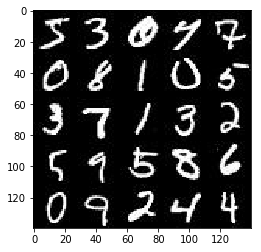

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

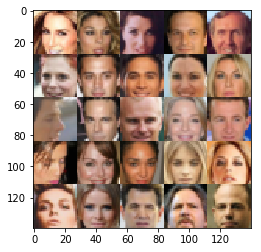

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    image_input = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='image_input')
    
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return image_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [38]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Begin by convolving features and introducing leaky ReLu/Dropout
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        d1 = tf.layers.dropout(relu1, 0.4)
        # 16x16x64 now
        
        # Introduce Batch normalization between activations for remaining layers
        x2 = tf.layers.conv2d(d1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        d2 = tf.layers.dropout(relu2, 0.4)
        # 8x8x128 now
        
        x3 = tf.layers.conv2d(d2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        d3 = tf.layers.dropout(relu3, 0.4)
        # 4x4x256 now
        
        x4 = tf.layers.conv2d(d3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        d4 = tf.layers.dropout(relu4, 0.4)
        # 2x2x512 now

        # Flatten and return logits/output
        flat = tf.reshape(d4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [39]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    #
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape for Convolution
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.nn.relu(bn1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.nn.relu(bn2)       
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.nn.relu(bn3)
        # 28x28x128 now
        
        x4 = tf.layers.conv2d_transpose(relu3, 64, 5, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.nn.relu(bn4)
        # 28x28x64 now
        
        x5 = tf.layers.conv2d_transpose(relu4, 32, 5, strides=1, padding='same')
        bn5 = tf.layers.batch_normalization(x5, training=is_train)
        relu5 = tf.nn.relu(bn5)
        # 28x28x32 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu5, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [40]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(.9))) #added label smoothing
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [43]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #print(data_shape)
    
    # get input placeholders
    image_input, z_input, lr_input = model_inputs(*data_shape[1:], z_dim)

    # build GAN and calculate losses
    d_loss, g_loss = model_loss(image_input, z_input, data_shape[-1])
    
    # optimize model
    d_train, g_train = model_opt(d_loss, g_loss, lr_input, beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    steps = 0
    batch_n = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                # sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_train, feed_dict={image_input: batch_images, z_input: batch_z, lr_input: learning_rate})
                _ = sess.run(g_train, feed_dict={z_input: batch_z, image_input: batch_images, lr_input: learning_rate})
                _ = sess.run(g_train, feed_dict={z_input: batch_z, image_input: batch_images, lr_input: learning_rate})
                
                if steps % 10 == 0:
                    batch_n += 1
                    train_loss_d = d_loss.eval({z_input: batch_z, image_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}/{}...".format(batch_n, (data_shape[0]/(batch_size*10))*epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 30, z_input, data_shape[-1], data_image_mode)
    

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Step 1/375.0... Discriminator Loss: 3.5257... Generator Loss: 0.0483
Epoch 1/2... Step 2/375.0... Discriminator Loss: 3.9287... Generator Loss: 0.0319
Epoch 1/2... Step 3/375.0... Discriminator Loss: 2.7411... Generator Loss: 0.1233
Epoch 1/2... Step 4/375.0... Discriminator Loss: 2.6054... Generator Loss: 0.2884
Epoch 1/2... Step 5/375.0... Discriminator Loss: 2.8556... Generator Loss: 0.1646
Epoch 1/2... Step 6/375.0... Discriminator Loss: 2.6422... Generator Loss: 0.1430
Epoch 1/2... Step 7/375.0... Discriminator Loss: 2.5046... Generator Loss: 0.1662
Epoch 1/2... Step 8/375.0... Discriminator Loss: 2.1930... Generator Loss: 0.5847
Epoch 1/2... Step 9/375.0... Discriminator Loss: 2.2504... Generator Loss: 0.2094
Epoch 1/2... Step 10/375.0... Discriminator Loss: 2.2210... Generator Loss: 0.2229


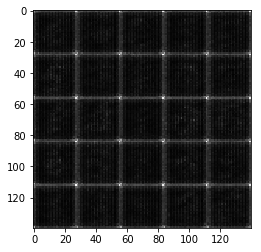

Epoch 1/2... Step 11/375.0... Discriminator Loss: 2.0836... Generator Loss: 0.2853
Epoch 1/2... Step 12/375.0... Discriminator Loss: 1.9532... Generator Loss: 0.3260
Epoch 1/2... Step 13/375.0... Discriminator Loss: 2.0308... Generator Loss: 0.2746
Epoch 1/2... Step 14/375.0... Discriminator Loss: 2.5468... Generator Loss: 0.1293
Epoch 1/2... Step 15/375.0... Discriminator Loss: 1.6878... Generator Loss: 0.5438
Epoch 1/2... Step 16/375.0... Discriminator Loss: 1.8874... Generator Loss: 0.3051
Epoch 1/2... Step 17/375.0... Discriminator Loss: 2.0501... Generator Loss: 0.5495
Epoch 1/2... Step 18/375.0... Discriminator Loss: 1.9975... Generator Loss: 0.2847
Epoch 1/2... Step 19/375.0... Discriminator Loss: 1.8258... Generator Loss: 0.3783
Epoch 1/2... Step 20/375.0... Discriminator Loss: 1.9416... Generator Loss: 0.3731


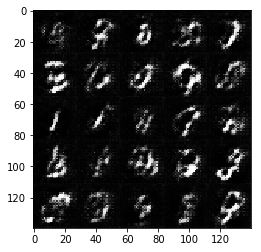

Epoch 1/2... Step 21/375.0... Discriminator Loss: 2.4838... Generator Loss: 0.1656
Epoch 1/2... Step 22/375.0... Discriminator Loss: 1.8632... Generator Loss: 0.3065
Epoch 1/2... Step 23/375.0... Discriminator Loss: 2.3875... Generator Loss: 0.1555
Epoch 1/2... Step 24/375.0... Discriminator Loss: 2.2184... Generator Loss: 0.2282
Epoch 1/2... Step 25/375.0... Discriminator Loss: 2.0274... Generator Loss: 0.3206
Epoch 1/2... Step 26/375.0... Discriminator Loss: 1.9289... Generator Loss: 0.3016
Epoch 1/2... Step 27/375.0... Discriminator Loss: 2.0383... Generator Loss: 0.3108
Epoch 1/2... Step 28/375.0... Discriminator Loss: 1.8986... Generator Loss: 0.3304
Epoch 1/2... Step 29/375.0... Discriminator Loss: 2.5727... Generator Loss: 0.1249
Epoch 1/2... Step 30/375.0... Discriminator Loss: 1.9528... Generator Loss: 0.2692


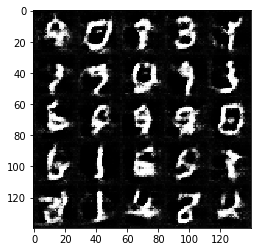

Epoch 1/2... Step 31/375.0... Discriminator Loss: 2.0773... Generator Loss: 0.2588
Epoch 1/2... Step 32/375.0... Discriminator Loss: 1.6951... Generator Loss: 0.5434
Epoch 1/2... Step 33/375.0... Discriminator Loss: 1.9124... Generator Loss: 0.3274
Epoch 1/2... Step 34/375.0... Discriminator Loss: 1.7700... Generator Loss: 0.4123
Epoch 1/2... Step 35/375.0... Discriminator Loss: 2.3345... Generator Loss: 0.1919
Epoch 1/2... Step 36/375.0... Discriminator Loss: 2.1225... Generator Loss: 0.2260
Epoch 1/2... Step 37/375.0... Discriminator Loss: 2.0112... Generator Loss: 0.2561
Epoch 1/2... Step 38/375.0... Discriminator Loss: 1.7722... Generator Loss: 0.3581
Epoch 1/2... Step 39/375.0... Discriminator Loss: 1.9148... Generator Loss: 0.2679
Epoch 1/2... Step 40/375.0... Discriminator Loss: 2.4012... Generator Loss: 0.1573


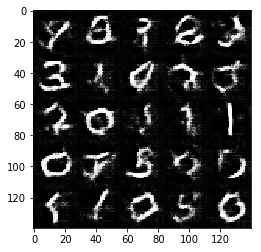

Epoch 1/2... Step 41/375.0... Discriminator Loss: 2.6770... Generator Loss: 0.1402
Epoch 1/2... Step 42/375.0... Discriminator Loss: 1.6264... Generator Loss: 0.4084
Epoch 1/2... Step 43/375.0... Discriminator Loss: 2.0154... Generator Loss: 0.3259
Epoch 1/2... Step 44/375.0... Discriminator Loss: 2.5544... Generator Loss: 0.1374
Epoch 1/2... Step 45/375.0... Discriminator Loss: 1.8509... Generator Loss: 0.3263
Epoch 1/2... Step 46/375.0... Discriminator Loss: 1.7326... Generator Loss: 0.5001
Epoch 1/2... Step 47/375.0... Discriminator Loss: 1.9277... Generator Loss: 0.3402
Epoch 1/2... Step 48/375.0... Discriminator Loss: 2.0981... Generator Loss: 0.2652
Epoch 1/2... Step 49/375.0... Discriminator Loss: 1.9985... Generator Loss: 0.2845
Epoch 1/2... Step 50/375.0... Discriminator Loss: 1.9202... Generator Loss: 0.3233


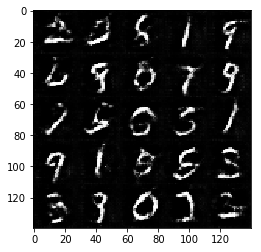

Epoch 1/2... Step 51/375.0... Discriminator Loss: 1.8260... Generator Loss: 0.3338
Epoch 1/2... Step 52/375.0... Discriminator Loss: 1.8869... Generator Loss: 0.3170
Epoch 1/2... Step 53/375.0... Discriminator Loss: 1.7798... Generator Loss: 0.3364
Epoch 1/2... Step 54/375.0... Discriminator Loss: 2.0197... Generator Loss: 0.2740
Epoch 1/2... Step 55/375.0... Discriminator Loss: 1.8466... Generator Loss: 0.5191
Epoch 1/2... Step 56/375.0... Discriminator Loss: 1.6998... Generator Loss: 0.4244
Epoch 1/2... Step 57/375.0... Discriminator Loss: 1.8671... Generator Loss: 0.3722
Epoch 1/2... Step 58/375.0... Discriminator Loss: 1.9230... Generator Loss: 0.3391
Epoch 1/2... Step 59/375.0... Discriminator Loss: 1.5341... Generator Loss: 0.4702
Epoch 1/2... Step 60/375.0... Discriminator Loss: 1.9836... Generator Loss: 0.2579


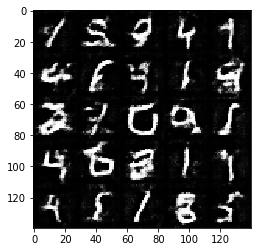

Epoch 1/2... Step 61/375.0... Discriminator Loss: 2.4920... Generator Loss: 0.1860
Epoch 1/2... Step 62/375.0... Discriminator Loss: 2.0125... Generator Loss: 0.3007
Epoch 1/2... Step 63/375.0... Discriminator Loss: 1.8854... Generator Loss: 0.2996
Epoch 1/2... Step 64/375.0... Discriminator Loss: 1.7747... Generator Loss: 0.3650
Epoch 1/2... Step 65/375.0... Discriminator Loss: 1.8645... Generator Loss: 0.4214
Epoch 1/2... Step 66/375.0... Discriminator Loss: 1.8095... Generator Loss: 0.3437
Epoch 1/2... Step 67/375.0... Discriminator Loss: 1.9973... Generator Loss: 0.3057
Epoch 1/2... Step 68/375.0... Discriminator Loss: 1.8839... Generator Loss: 0.3294
Epoch 1/2... Step 69/375.0... Discriminator Loss: 2.0240... Generator Loss: 0.3147
Epoch 1/2... Step 70/375.0... Discriminator Loss: 1.9775... Generator Loss: 0.2955


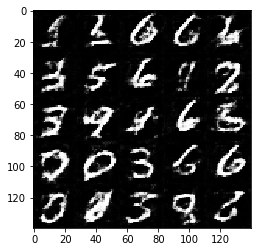

Epoch 1/2... Step 71/375.0... Discriminator Loss: 2.8849... Generator Loss: 0.0906
Epoch 1/2... Step 72/375.0... Discriminator Loss: 1.7703... Generator Loss: 0.4076
Epoch 1/2... Step 73/375.0... Discriminator Loss: 1.8253... Generator Loss: 0.3092
Epoch 1/2... Step 74/375.0... Discriminator Loss: 2.0486... Generator Loss: 0.2746
Epoch 1/2... Step 75/375.0... Discriminator Loss: 1.8003... Generator Loss: 0.4886
Epoch 1/2... Step 76/375.0... Discriminator Loss: 1.3536... Generator Loss: 0.5713
Epoch 1/2... Step 77/375.0... Discriminator Loss: 1.8541... Generator Loss: 0.3210
Epoch 1/2... Step 78/375.0... Discriminator Loss: 2.0220... Generator Loss: 0.2568
Epoch 1/2... Step 79/375.0... Discriminator Loss: 1.7844... Generator Loss: 0.3022
Epoch 1/2... Step 80/375.0... Discriminator Loss: 2.4949... Generator Loss: 0.1677


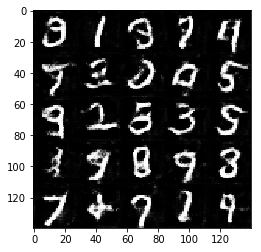

Epoch 1/2... Step 81/375.0... Discriminator Loss: 1.5687... Generator Loss: 0.4301
Epoch 1/2... Step 82/375.0... Discriminator Loss: 1.9203... Generator Loss: 0.3273
Epoch 1/2... Step 83/375.0... Discriminator Loss: 1.7922... Generator Loss: 0.3071
Epoch 1/2... Step 84/375.0... Discriminator Loss: 1.7238... Generator Loss: 0.4107
Epoch 1/2... Step 85/375.0... Discriminator Loss: 1.6976... Generator Loss: 0.4872
Epoch 1/2... Step 86/375.0... Discriminator Loss: 1.6549... Generator Loss: 0.4089
Epoch 1/2... Step 87/375.0... Discriminator Loss: 1.8215... Generator Loss: 0.3470
Epoch 1/2... Step 88/375.0... Discriminator Loss: 2.1291... Generator Loss: 0.2579
Epoch 1/2... Step 89/375.0... Discriminator Loss: 1.9889... Generator Loss: 0.2798
Epoch 1/2... Step 90/375.0... Discriminator Loss: 1.9313... Generator Loss: 0.2648


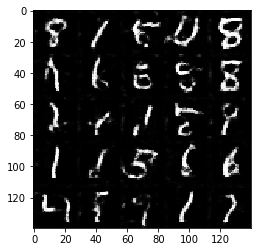

Epoch 1/2... Step 91/375.0... Discriminator Loss: 1.4904... Generator Loss: 0.5091
Epoch 1/2... Step 92/375.0... Discriminator Loss: 1.6618... Generator Loss: 0.4346
Epoch 1/2... Step 93/375.0... Discriminator Loss: 1.8579... Generator Loss: 0.3109
Epoch 1/2... Step 94/375.0... Discriminator Loss: 2.0535... Generator Loss: 0.2750
Epoch 1/2... Step 95/375.0... Discriminator Loss: 1.4796... Generator Loss: 0.5200
Epoch 1/2... Step 96/375.0... Discriminator Loss: 1.7923... Generator Loss: 0.3320
Epoch 1/2... Step 97/375.0... Discriminator Loss: 2.1119... Generator Loss: 0.2260
Epoch 1/2... Step 98/375.0... Discriminator Loss: 1.3991... Generator Loss: 0.5981
Epoch 1/2... Step 99/375.0... Discriminator Loss: 2.2955... Generator Loss: 0.1737
Epoch 1/2... Step 100/375.0... Discriminator Loss: 1.9200... Generator Loss: 0.2712


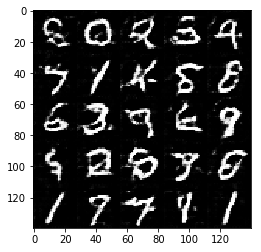

Epoch 1/2... Step 101/375.0... Discriminator Loss: 1.7285... Generator Loss: 0.3692
Epoch 1/2... Step 102/375.0... Discriminator Loss: 1.9976... Generator Loss: 0.3226
Epoch 1/2... Step 103/375.0... Discriminator Loss: 1.8281... Generator Loss: 0.3288
Epoch 1/2... Step 104/375.0... Discriminator Loss: 2.0410... Generator Loss: 0.2543
Epoch 1/2... Step 105/375.0... Discriminator Loss: 1.7311... Generator Loss: 0.3441
Epoch 1/2... Step 106/375.0... Discriminator Loss: 1.6184... Generator Loss: 0.4844
Epoch 1/2... Step 107/375.0... Discriminator Loss: 1.7887... Generator Loss: 0.3489
Epoch 1/2... Step 108/375.0... Discriminator Loss: 1.9169... Generator Loss: 0.3043
Epoch 1/2... Step 109/375.0... Discriminator Loss: 2.1681... Generator Loss: 0.1942
Epoch 1/2... Step 110/375.0... Discriminator Loss: 2.2631... Generator Loss: 0.1848


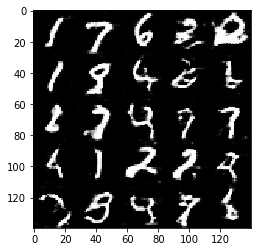

Epoch 1/2... Step 111/375.0... Discriminator Loss: 1.7547... Generator Loss: 0.6252
Epoch 1/2... Step 112/375.0... Discriminator Loss: 1.7785... Generator Loss: 0.4131
Epoch 1/2... Step 113/375.0... Discriminator Loss: 1.5573... Generator Loss: 0.5318
Epoch 1/2... Step 114/375.0... Discriminator Loss: 1.8225... Generator Loss: 0.3432
Epoch 1/2... Step 115/375.0... Discriminator Loss: 1.5043... Generator Loss: 1.0215
Epoch 1/2... Step 116/375.0... Discriminator Loss: 2.0241... Generator Loss: 0.2383
Epoch 1/2... Step 117/375.0... Discriminator Loss: 1.9119... Generator Loss: 0.2961
Epoch 1/2... Step 118/375.0... Discriminator Loss: 1.4677... Generator Loss: 0.5085
Epoch 1/2... Step 119/375.0... Discriminator Loss: 1.4779... Generator Loss: 0.5050
Epoch 1/2... Step 120/375.0... Discriminator Loss: 1.6781... Generator Loss: 0.3660


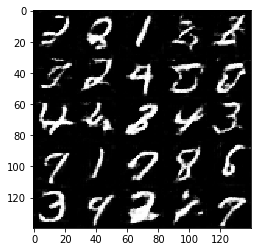

Epoch 1/2... Step 121/375.0... Discriminator Loss: 1.2355... Generator Loss: 0.8266
Epoch 1/2... Step 122/375.0... Discriminator Loss: 1.8072... Generator Loss: 0.4028
Epoch 1/2... Step 123/375.0... Discriminator Loss: 1.9291... Generator Loss: 0.4547
Epoch 1/2... Step 124/375.0... Discriminator Loss: 1.6248... Generator Loss: 0.4076
Epoch 1/2... Step 125/375.0... Discriminator Loss: 1.6525... Generator Loss: 0.5190
Epoch 1/2... Step 126/375.0... Discriminator Loss: 1.5857... Generator Loss: 0.4659
Epoch 1/2... Step 127/375.0... Discriminator Loss: 1.9203... Generator Loss: 0.2835
Epoch 1/2... Step 128/375.0... Discriminator Loss: 1.8217... Generator Loss: 0.3590
Epoch 1/2... Step 129/375.0... Discriminator Loss: 2.0601... Generator Loss: 0.2385
Epoch 1/2... Step 130/375.0... Discriminator Loss: 1.7727... Generator Loss: 0.3742


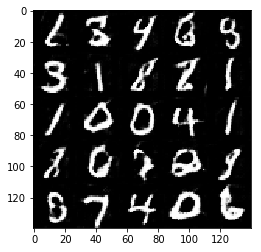

Epoch 1/2... Step 131/375.0... Discriminator Loss: 1.5289... Generator Loss: 0.4604
Epoch 1/2... Step 132/375.0... Discriminator Loss: 1.8632... Generator Loss: 0.3474
Epoch 1/2... Step 133/375.0... Discriminator Loss: 1.5402... Generator Loss: 0.5465
Epoch 1/2... Step 134/375.0... Discriminator Loss: 1.5928... Generator Loss: 0.4550
Epoch 1/2... Step 135/375.0... Discriminator Loss: 1.8587... Generator Loss: 0.3082
Epoch 1/2... Step 136/375.0... Discriminator Loss: 1.8334... Generator Loss: 0.4196
Epoch 1/2... Step 137/375.0... Discriminator Loss: 1.5820... Generator Loss: 0.4109
Epoch 1/2... Step 138/375.0... Discriminator Loss: 2.1026... Generator Loss: 0.2383
Epoch 1/2... Step 139/375.0... Discriminator Loss: 2.0672... Generator Loss: 0.2508
Epoch 1/2... Step 140/375.0... Discriminator Loss: 1.9101... Generator Loss: 0.2776


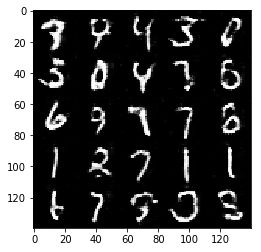

Epoch 1/2... Step 141/375.0... Discriminator Loss: 1.9225... Generator Loss: 0.3773
Epoch 1/2... Step 142/375.0... Discriminator Loss: 1.5936... Generator Loss: 0.3976
Epoch 1/2... Step 143/375.0... Discriminator Loss: 2.0221... Generator Loss: 0.2605
Epoch 1/2... Step 144/375.0... Discriminator Loss: 1.4216... Generator Loss: 0.4945
Epoch 1/2... Step 145/375.0... Discriminator Loss: 1.6026... Generator Loss: 0.4404
Epoch 1/2... Step 146/375.0... Discriminator Loss: 1.3567... Generator Loss: 0.7764
Epoch 1/2... Step 147/375.0... Discriminator Loss: 2.2116... Generator Loss: 0.2204
Epoch 1/2... Step 148/375.0... Discriminator Loss: 1.7228... Generator Loss: 0.3643
Epoch 1/2... Step 149/375.0... Discriminator Loss: 2.2662... Generator Loss: 0.2158
Epoch 1/2... Step 150/375.0... Discriminator Loss: 1.6367... Generator Loss: 0.4154


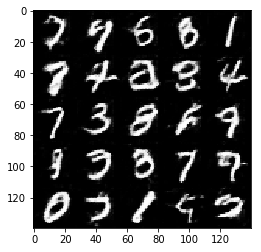

Epoch 1/2... Step 151/375.0... Discriminator Loss: 1.8100... Generator Loss: 0.3666
Epoch 1/2... Step 152/375.0... Discriminator Loss: 1.5658... Generator Loss: 0.5154
Epoch 1/2... Step 153/375.0... Discriminator Loss: 1.7170... Generator Loss: 0.4581
Epoch 1/2... Step 154/375.0... Discriminator Loss: 1.7949... Generator Loss: 0.3235
Epoch 1/2... Step 155/375.0... Discriminator Loss: 2.3049... Generator Loss: 0.1677
Epoch 1/2... Step 156/375.0... Discriminator Loss: 1.6737... Generator Loss: 0.5537
Epoch 1/2... Step 157/375.0... Discriminator Loss: 1.8692... Generator Loss: 0.3023
Epoch 1/2... Step 158/375.0... Discriminator Loss: 1.7754... Generator Loss: 0.3655
Epoch 1/2... Step 159/375.0... Discriminator Loss: 1.5896... Generator Loss: 0.3737
Epoch 1/2... Step 160/375.0... Discriminator Loss: 1.8490... Generator Loss: 0.3297


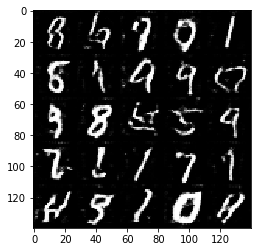

Epoch 1/2... Step 161/375.0... Discriminator Loss: 1.9500... Generator Loss: 0.3422
Epoch 1/2... Step 162/375.0... Discriminator Loss: 1.9238... Generator Loss: 0.3103
Epoch 1/2... Step 163/375.0... Discriminator Loss: 1.7096... Generator Loss: 0.5129
Epoch 1/2... Step 164/375.0... Discriminator Loss: 1.8695... Generator Loss: 0.3723
Epoch 1/2... Step 165/375.0... Discriminator Loss: 1.2663... Generator Loss: 0.6900
Epoch 1/2... Step 166/375.0... Discriminator Loss: 1.6008... Generator Loss: 0.5334
Epoch 1/2... Step 167/375.0... Discriminator Loss: 1.8103... Generator Loss: 0.3245
Epoch 1/2... Step 168/375.0... Discriminator Loss: 1.6545... Generator Loss: 0.4160
Epoch 1/2... Step 169/375.0... Discriminator Loss: 1.9024... Generator Loss: 0.3389
Epoch 1/2... Step 170/375.0... Discriminator Loss: 1.6437... Generator Loss: 0.4123


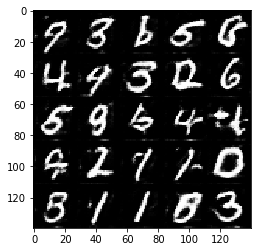

Epoch 1/2... Step 171/375.0... Discriminator Loss: 1.4718... Generator Loss: 0.4639
Epoch 1/2... Step 172/375.0... Discriminator Loss: 1.8939... Generator Loss: 0.2949
Epoch 1/2... Step 173/375.0... Discriminator Loss: 1.7524... Generator Loss: 0.4265
Epoch 1/2... Step 174/375.0... Discriminator Loss: 1.7014... Generator Loss: 0.4661
Epoch 1/2... Step 175/375.0... Discriminator Loss: 1.5232... Generator Loss: 0.4809
Epoch 1/2... Step 176/375.0... Discriminator Loss: 1.7843... Generator Loss: 0.3080
Epoch 1/2... Step 177/375.0... Discriminator Loss: 1.9884... Generator Loss: 0.2989
Epoch 1/2... Step 178/375.0... Discriminator Loss: 1.4665... Generator Loss: 0.5234
Epoch 1/2... Step 179/375.0... Discriminator Loss: 1.4669... Generator Loss: 0.4988
Epoch 1/2... Step 180/375.0... Discriminator Loss: 1.7439... Generator Loss: 0.3851


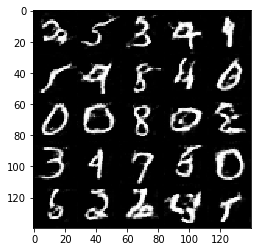

Epoch 1/2... Step 181/375.0... Discriminator Loss: 2.0285... Generator Loss: 0.2358
Epoch 1/2... Step 182/375.0... Discriminator Loss: 1.7974... Generator Loss: 0.3455
Epoch 1/2... Step 183/375.0... Discriminator Loss: 2.1652... Generator Loss: 0.2136
Epoch 1/2... Step 184/375.0... Discriminator Loss: 1.6524... Generator Loss: 0.3882
Epoch 1/2... Step 185/375.0... Discriminator Loss: 1.5534... Generator Loss: 0.4570
Epoch 1/2... Step 186/375.0... Discriminator Loss: 1.8940... Generator Loss: 0.2995
Epoch 1/2... Step 187/375.0... Discriminator Loss: 1.3811... Generator Loss: 0.5397
Epoch 2/2... Step 188/375.0... Discriminator Loss: 1.3836... Generator Loss: 0.5184
Epoch 2/2... Step 189/375.0... Discriminator Loss: 1.6067... Generator Loss: 0.4521
Epoch 2/2... Step 190/375.0... Discriminator Loss: 1.3085... Generator Loss: 0.5887


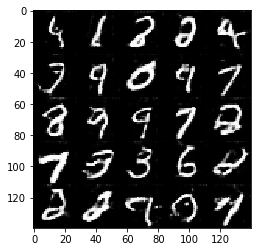

Epoch 2/2... Step 191/375.0... Discriminator Loss: 1.8993... Generator Loss: 0.2966
Epoch 2/2... Step 192/375.0... Discriminator Loss: 1.8488... Generator Loss: 0.3067
Epoch 2/2... Step 193/375.0... Discriminator Loss: 2.0050... Generator Loss: 0.2298
Epoch 2/2... Step 194/375.0... Discriminator Loss: 1.8945... Generator Loss: 0.2985
Epoch 2/2... Step 195/375.0... Discriminator Loss: 1.8375... Generator Loss: 0.2900
Epoch 2/2... Step 196/375.0... Discriminator Loss: 1.7724... Generator Loss: 0.3962
Epoch 2/2... Step 197/375.0... Discriminator Loss: 1.9442... Generator Loss: 0.3507
Epoch 2/2... Step 198/375.0... Discriminator Loss: 1.8530... Generator Loss: 0.3060
Epoch 2/2... Step 199/375.0... Discriminator Loss: 1.5270... Generator Loss: 0.5207
Epoch 2/2... Step 200/375.0... Discriminator Loss: 2.1960... Generator Loss: 0.2071


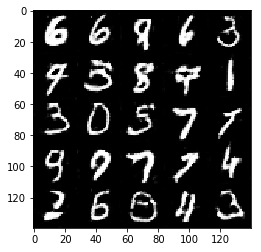

Epoch 2/2... Step 201/375.0... Discriminator Loss: 1.8892... Generator Loss: 0.2792
Epoch 2/2... Step 202/375.0... Discriminator Loss: 1.7002... Generator Loss: 0.3581
Epoch 2/2... Step 203/375.0... Discriminator Loss: 1.8060... Generator Loss: 0.3445
Epoch 2/2... Step 204/375.0... Discriminator Loss: 1.5551... Generator Loss: 0.6018
Epoch 2/2... Step 205/375.0... Discriminator Loss: 2.1378... Generator Loss: 0.2373
Epoch 2/2... Step 206/375.0... Discriminator Loss: 1.7146... Generator Loss: 0.3701
Epoch 2/2... Step 207/375.0... Discriminator Loss: 1.4211... Generator Loss: 0.5007
Epoch 2/2... Step 208/375.0... Discriminator Loss: 2.0303... Generator Loss: 0.2640
Epoch 2/2... Step 209/375.0... Discriminator Loss: 1.9954... Generator Loss: 0.4580
Epoch 2/2... Step 210/375.0... Discriminator Loss: 1.8131... Generator Loss: 0.4573


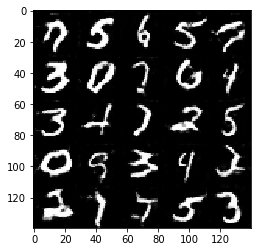

Epoch 2/2... Step 211/375.0... Discriminator Loss: 1.7842... Generator Loss: 0.3242
Epoch 2/2... Step 212/375.0... Discriminator Loss: 1.4302... Generator Loss: 0.5269
Epoch 2/2... Step 213/375.0... Discriminator Loss: 1.7339... Generator Loss: 0.3731
Epoch 2/2... Step 214/375.0... Discriminator Loss: 1.8557... Generator Loss: 0.3146
Epoch 2/2... Step 215/375.0... Discriminator Loss: 1.6325... Generator Loss: 0.3991
Epoch 2/2... Step 216/375.0... Discriminator Loss: 1.8698... Generator Loss: 0.2896
Epoch 2/2... Step 217/375.0... Discriminator Loss: 1.7374... Generator Loss: 0.3610
Epoch 2/2... Step 218/375.0... Discriminator Loss: 2.0424... Generator Loss: 0.2559
Epoch 2/2... Step 219/375.0... Discriminator Loss: 1.6175... Generator Loss: 0.4081
Epoch 2/2... Step 220/375.0... Discriminator Loss: 1.9311... Generator Loss: 0.2820


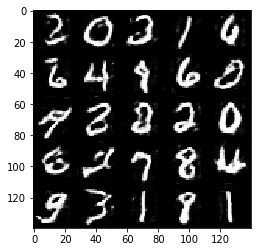

Epoch 2/2... Step 221/375.0... Discriminator Loss: 1.6689... Generator Loss: 0.4134
Epoch 2/2... Step 222/375.0... Discriminator Loss: 1.9401... Generator Loss: 0.3045
Epoch 2/2... Step 223/375.0... Discriminator Loss: 2.0448... Generator Loss: 0.3204
Epoch 2/2... Step 224/375.0... Discriminator Loss: 1.9166... Generator Loss: 0.2858
Epoch 2/2... Step 225/375.0... Discriminator Loss: 1.9693... Generator Loss: 0.2816
Epoch 2/2... Step 226/375.0... Discriminator Loss: 2.1270... Generator Loss: 0.2279
Epoch 2/2... Step 227/375.0... Discriminator Loss: 1.6314... Generator Loss: 0.5666
Epoch 2/2... Step 228/375.0... Discriminator Loss: 1.5897... Generator Loss: 0.4552
Epoch 2/2... Step 229/375.0... Discriminator Loss: 1.6408... Generator Loss: 0.3848
Epoch 2/2... Step 230/375.0... Discriminator Loss: 1.8206... Generator Loss: 0.3111


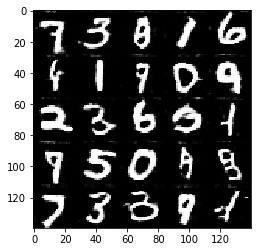

Epoch 2/2... Step 231/375.0... Discriminator Loss: 1.5799... Generator Loss: 0.4452
Epoch 2/2... Step 232/375.0... Discriminator Loss: 2.1277... Generator Loss: 0.2404
Epoch 2/2... Step 233/375.0... Discriminator Loss: 1.7722... Generator Loss: 0.3588
Epoch 2/2... Step 234/375.0... Discriminator Loss: 2.2664... Generator Loss: 0.2002
Epoch 2/2... Step 235/375.0... Discriminator Loss: 1.5966... Generator Loss: 0.4327
Epoch 2/2... Step 236/375.0... Discriminator Loss: 1.6371... Generator Loss: 0.4032
Epoch 2/2... Step 237/375.0... Discriminator Loss: 1.8985... Generator Loss: 0.3300
Epoch 2/2... Step 238/375.0... Discriminator Loss: 1.7069... Generator Loss: 0.3702
Epoch 2/2... Step 239/375.0... Discriminator Loss: 1.3537... Generator Loss: 0.5575
Epoch 2/2... Step 240/375.0... Discriminator Loss: 2.0622... Generator Loss: 0.2423


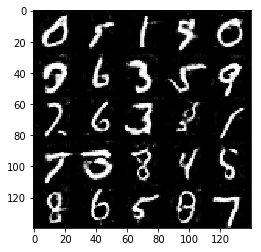

Epoch 2/2... Step 241/375.0... Discriminator Loss: 2.0903... Generator Loss: 0.2404
Epoch 2/2... Step 242/375.0... Discriminator Loss: 1.4854... Generator Loss: 0.5193
Epoch 2/2... Step 243/375.0... Discriminator Loss: 1.6603... Generator Loss: 0.4226
Epoch 2/2... Step 244/375.0... Discriminator Loss: 1.9476... Generator Loss: 0.3293
Epoch 2/2... Step 245/375.0... Discriminator Loss: 1.4877... Generator Loss: 0.4959
Epoch 2/2... Step 246/375.0... Discriminator Loss: 1.8341... Generator Loss: 0.3325
Epoch 2/2... Step 247/375.0... Discriminator Loss: 1.8875... Generator Loss: 0.2955
Epoch 2/2... Step 248/375.0... Discriminator Loss: 2.2413... Generator Loss: 0.2010
Epoch 2/2... Step 249/375.0... Discriminator Loss: 1.8550... Generator Loss: 0.3304
Epoch 2/2... Step 250/375.0... Discriminator Loss: 1.9041... Generator Loss: 0.2992


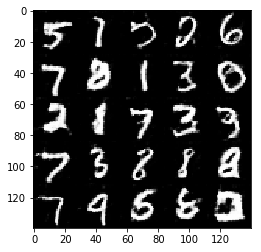

Epoch 2/2... Step 251/375.0... Discriminator Loss: 1.7058... Generator Loss: 0.3881
Epoch 2/2... Step 252/375.0... Discriminator Loss: 1.6061... Generator Loss: 0.4225
Epoch 2/2... Step 253/375.0... Discriminator Loss: 1.8098... Generator Loss: 0.2937
Epoch 2/2... Step 254/375.0... Discriminator Loss: 2.1572... Generator Loss: 0.2475
Epoch 2/2... Step 255/375.0... Discriminator Loss: 2.2038... Generator Loss: 0.2101
Epoch 2/2... Step 256/375.0... Discriminator Loss: 1.6548... Generator Loss: 0.4288
Epoch 2/2... Step 257/375.0... Discriminator Loss: 1.5756... Generator Loss: 0.4177
Epoch 2/2... Step 258/375.0... Discriminator Loss: 1.7337... Generator Loss: 0.4795
Epoch 2/2... Step 259/375.0... Discriminator Loss: 1.8225... Generator Loss: 0.4196
Epoch 2/2... Step 260/375.0... Discriminator Loss: 1.3938... Generator Loss: 0.5761


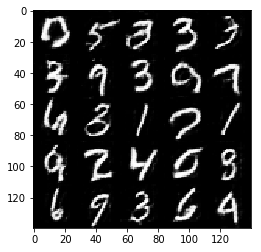

Epoch 2/2... Step 261/375.0... Discriminator Loss: 1.8294... Generator Loss: 0.2920
Epoch 2/2... Step 262/375.0... Discriminator Loss: 1.7430... Generator Loss: 0.3744
Epoch 2/2... Step 263/375.0... Discriminator Loss: 2.0240... Generator Loss: 0.2813
Epoch 2/2... Step 264/375.0... Discriminator Loss: 2.3273... Generator Loss: 0.3090
Epoch 2/2... Step 265/375.0... Discriminator Loss: 1.9723... Generator Loss: 0.2582
Epoch 2/2... Step 266/375.0... Discriminator Loss: 2.3090... Generator Loss: 0.1932
Epoch 2/2... Step 267/375.0... Discriminator Loss: 1.9319... Generator Loss: 0.4946
Epoch 2/2... Step 268/375.0... Discriminator Loss: 1.5355... Generator Loss: 0.7794
Epoch 2/2... Step 269/375.0... Discriminator Loss: 1.4895... Generator Loss: 0.4526
Epoch 2/2... Step 270/375.0... Discriminator Loss: 2.1572... Generator Loss: 0.2505


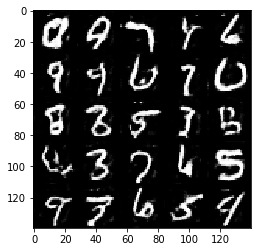

Epoch 2/2... Step 271/375.0... Discriminator Loss: 1.3147... Generator Loss: 0.5939
Epoch 2/2... Step 272/375.0... Discriminator Loss: 2.1376... Generator Loss: 0.2245
Epoch 2/2... Step 273/375.0... Discriminator Loss: 1.9015... Generator Loss: 0.3065
Epoch 2/2... Step 274/375.0... Discriminator Loss: 1.4048... Generator Loss: 0.5389
Epoch 2/2... Step 275/375.0... Discriminator Loss: 2.0058... Generator Loss: 0.2649
Epoch 2/2... Step 276/375.0... Discriminator Loss: 1.9002... Generator Loss: 0.2932
Epoch 2/2... Step 277/375.0... Discriminator Loss: 1.7770... Generator Loss: 0.3759
Epoch 2/2... Step 278/375.0... Discriminator Loss: 2.2142... Generator Loss: 0.2351
Epoch 2/2... Step 279/375.0... Discriminator Loss: 2.1840... Generator Loss: 0.1974
Epoch 2/2... Step 280/375.0... Discriminator Loss: 1.5031... Generator Loss: 0.5887


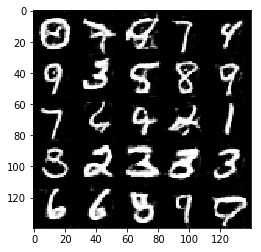

Epoch 2/2... Step 281/375.0... Discriminator Loss: 1.7265... Generator Loss: 0.3692
Epoch 2/2... Step 282/375.0... Discriminator Loss: 1.7079... Generator Loss: 0.4677
Epoch 2/2... Step 283/375.0... Discriminator Loss: 1.8104... Generator Loss: 0.3499
Epoch 2/2... Step 284/375.0... Discriminator Loss: 1.6061... Generator Loss: 0.6342
Epoch 2/2... Step 285/375.0... Discriminator Loss: 2.1093... Generator Loss: 0.2457
Epoch 2/2... Step 286/375.0... Discriminator Loss: 2.1161... Generator Loss: 0.2882
Epoch 2/2... Step 287/375.0... Discriminator Loss: 1.5689... Generator Loss: 0.4466
Epoch 2/2... Step 288/375.0... Discriminator Loss: 1.7028... Generator Loss: 0.4061
Epoch 2/2... Step 289/375.0... Discriminator Loss: 1.7523... Generator Loss: 0.3149
Epoch 2/2... Step 290/375.0... Discriminator Loss: 1.7345... Generator Loss: 0.3464


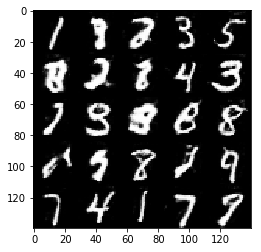

Epoch 2/2... Step 291/375.0... Discriminator Loss: 1.4125... Generator Loss: 0.5742
Epoch 2/2... Step 292/375.0... Discriminator Loss: 1.9537... Generator Loss: 0.2878
Epoch 2/2... Step 293/375.0... Discriminator Loss: 1.7291... Generator Loss: 0.3401
Epoch 2/2... Step 294/375.0... Discriminator Loss: 2.1136... Generator Loss: 0.2938
Epoch 2/2... Step 295/375.0... Discriminator Loss: 1.1858... Generator Loss: 0.6986
Epoch 2/2... Step 296/375.0... Discriminator Loss: 1.4246... Generator Loss: 0.6038
Epoch 2/2... Step 297/375.0... Discriminator Loss: 1.8711... Generator Loss: 0.2729
Epoch 2/2... Step 298/375.0... Discriminator Loss: 1.5732... Generator Loss: 0.4620
Epoch 2/2... Step 299/375.0... Discriminator Loss: 1.6757... Generator Loss: 0.4991
Epoch 2/2... Step 300/375.0... Discriminator Loss: 1.8365... Generator Loss: 0.3334


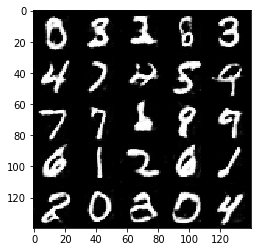

Epoch 2/2... Step 301/375.0... Discriminator Loss: 2.0183... Generator Loss: 0.2400
Epoch 2/2... Step 302/375.0... Discriminator Loss: 1.9004... Generator Loss: 0.2928
Epoch 2/2... Step 303/375.0... Discriminator Loss: 1.7937... Generator Loss: 0.3624
Epoch 2/2... Step 304/375.0... Discriminator Loss: 2.0304... Generator Loss: 0.2852
Epoch 2/2... Step 305/375.0... Discriminator Loss: 1.7327... Generator Loss: 0.3414
Epoch 2/2... Step 306/375.0... Discriminator Loss: 1.5928... Generator Loss: 0.4472
Epoch 2/2... Step 307/375.0... Discriminator Loss: 1.3983... Generator Loss: 0.4734
Epoch 2/2... Step 308/375.0... Discriminator Loss: 1.6735... Generator Loss: 0.3888
Epoch 2/2... Step 309/375.0... Discriminator Loss: 2.0784... Generator Loss: 0.2297
Epoch 2/2... Step 310/375.0... Discriminator Loss: 1.5831... Generator Loss: 0.3814


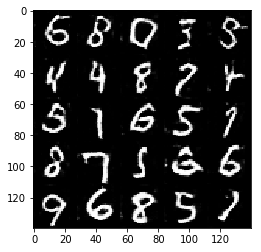

Epoch 2/2... Step 311/375.0... Discriminator Loss: 1.8180... Generator Loss: 0.3300
Epoch 2/2... Step 312/375.0... Discriminator Loss: 1.6861... Generator Loss: 0.4029
Epoch 2/2... Step 313/375.0... Discriminator Loss: 2.4223... Generator Loss: 0.1470
Epoch 2/2... Step 314/375.0... Discriminator Loss: 1.8842... Generator Loss: 0.2973
Epoch 2/2... Step 315/375.0... Discriminator Loss: 1.7989... Generator Loss: 0.3316
Epoch 2/2... Step 316/375.0... Discriminator Loss: 1.4477... Generator Loss: 0.5290
Epoch 2/2... Step 317/375.0... Discriminator Loss: 2.0538... Generator Loss: 0.2350
Epoch 2/2... Step 318/375.0... Discriminator Loss: 2.0956... Generator Loss: 0.2531
Epoch 2/2... Step 319/375.0... Discriminator Loss: 2.1264... Generator Loss: 0.3491
Epoch 2/2... Step 320/375.0... Discriminator Loss: 1.8701... Generator Loss: 0.2830


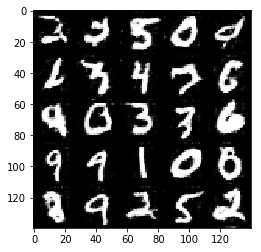

Epoch 2/2... Step 321/375.0... Discriminator Loss: 1.7924... Generator Loss: 0.3531
Epoch 2/2... Step 322/375.0... Discriminator Loss: 2.0104... Generator Loss: 0.2553
Epoch 2/2... Step 323/375.0... Discriminator Loss: 2.1379... Generator Loss: 0.2367
Epoch 2/2... Step 324/375.0... Discriminator Loss: 2.0268... Generator Loss: 0.3019
Epoch 2/2... Step 325/375.0... Discriminator Loss: 1.9371... Generator Loss: 0.2631
Epoch 2/2... Step 326/375.0... Discriminator Loss: 1.7595... Generator Loss: 0.3162
Epoch 2/2... Step 327/375.0... Discriminator Loss: 2.1176... Generator Loss: 0.2338
Epoch 2/2... Step 328/375.0... Discriminator Loss: 1.7776... Generator Loss: 0.3363
Epoch 2/2... Step 329/375.0... Discriminator Loss: 1.7468... Generator Loss: 0.3432
Epoch 2/2... Step 330/375.0... Discriminator Loss: 1.6995... Generator Loss: 0.3770


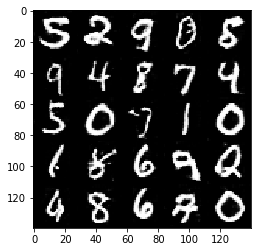

Epoch 2/2... Step 331/375.0... Discriminator Loss: 1.6106... Generator Loss: 0.4666
Epoch 2/2... Step 332/375.0... Discriminator Loss: 1.9868... Generator Loss: 0.2727
Epoch 2/2... Step 333/375.0... Discriminator Loss: 1.9345... Generator Loss: 0.2998
Epoch 2/2... Step 334/375.0... Discriminator Loss: 1.5334... Generator Loss: 0.4317
Epoch 2/2... Step 335/375.0... Discriminator Loss: 1.7425... Generator Loss: 0.3812
Epoch 2/2... Step 336/375.0... Discriminator Loss: 1.8258... Generator Loss: 0.3161
Epoch 2/2... Step 337/375.0... Discriminator Loss: 1.8679... Generator Loss: 0.2977
Epoch 2/2... Step 338/375.0... Discriminator Loss: 2.0049... Generator Loss: 0.2816
Epoch 2/2... Step 339/375.0... Discriminator Loss: 1.7584... Generator Loss: 0.3956
Epoch 2/2... Step 340/375.0... Discriminator Loss: 2.1034... Generator Loss: 0.2272


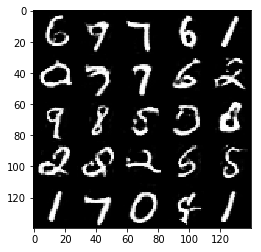

Epoch 2/2... Step 341/375.0... Discriminator Loss: 1.9222... Generator Loss: 0.3178
Epoch 2/2... Step 342/375.0... Discriminator Loss: 2.0006... Generator Loss: 0.2474
Epoch 2/2... Step 343/375.0... Discriminator Loss: 1.6188... Generator Loss: 0.4172
Epoch 2/2... Step 344/375.0... Discriminator Loss: 2.1975... Generator Loss: 0.2028
Epoch 2/2... Step 345/375.0... Discriminator Loss: 1.7910... Generator Loss: 0.3287
Epoch 2/2... Step 346/375.0... Discriminator Loss: 1.5928... Generator Loss: 0.4610
Epoch 2/2... Step 347/375.0... Discriminator Loss: 1.8754... Generator Loss: 0.3743
Epoch 2/2... Step 348/375.0... Discriminator Loss: 1.5090... Generator Loss: 0.4278
Epoch 2/2... Step 349/375.0... Discriminator Loss: 1.7205... Generator Loss: 0.3582
Epoch 2/2... Step 350/375.0... Discriminator Loss: 1.8875... Generator Loss: 0.2793


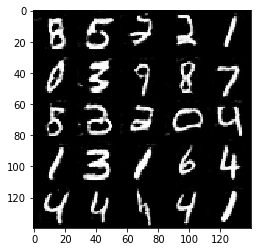

Epoch 2/2... Step 351/375.0... Discriminator Loss: 1.5297... Generator Loss: 0.4430
Epoch 2/2... Step 352/375.0... Discriminator Loss: 1.7087... Generator Loss: 0.4028
Epoch 2/2... Step 353/375.0... Discriminator Loss: 2.5089... Generator Loss: 0.1438
Epoch 2/2... Step 354/375.0... Discriminator Loss: 1.7707... Generator Loss: 0.3644
Epoch 2/2... Step 355/375.0... Discriminator Loss: 2.1410... Generator Loss: 0.2184
Epoch 2/2... Step 356/375.0... Discriminator Loss: 2.1043... Generator Loss: 0.2182
Epoch 2/2... Step 357/375.0... Discriminator Loss: 1.8591... Generator Loss: 0.2839
Epoch 2/2... Step 358/375.0... Discriminator Loss: 1.5576... Generator Loss: 0.3887
Epoch 2/2... Step 359/375.0... Discriminator Loss: 2.3537... Generator Loss: 0.1664
Epoch 2/2... Step 360/375.0... Discriminator Loss: 1.7515... Generator Loss: 0.4706


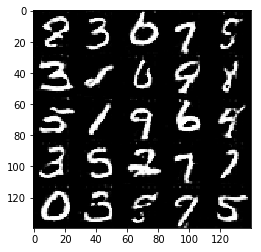

Epoch 2/2... Step 361/375.0... Discriminator Loss: 1.4540... Generator Loss: 0.4407
Epoch 2/2... Step 362/375.0... Discriminator Loss: 1.6012... Generator Loss: 0.3736
Epoch 2/2... Step 363/375.0... Discriminator Loss: 1.5435... Generator Loss: 0.4927
Epoch 2/2... Step 364/375.0... Discriminator Loss: 1.7218... Generator Loss: 0.3709
Epoch 2/2... Step 365/375.0... Discriminator Loss: 1.8622... Generator Loss: 0.3002
Epoch 2/2... Step 366/375.0... Discriminator Loss: 1.9391... Generator Loss: 0.2852
Epoch 2/2... Step 367/375.0... Discriminator Loss: 1.8212... Generator Loss: 0.3213
Epoch 2/2... Step 368/375.0... Discriminator Loss: 2.2481... Generator Loss: 0.2091
Epoch 2/2... Step 369/375.0... Discriminator Loss: 1.5857... Generator Loss: 0.4746
Epoch 2/2... Step 370/375.0... Discriminator Loss: 2.0852... Generator Loss: 0.2686


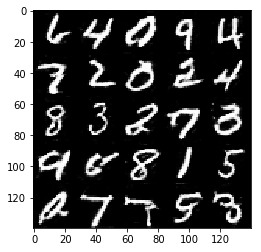

Epoch 2/2... Step 371/375.0... Discriminator Loss: 1.8668... Generator Loss: 0.3786
Epoch 2/2... Step 372/375.0... Discriminator Loss: 1.6991... Generator Loss: 0.3432
Epoch 2/2... Step 373/375.0... Discriminator Loss: 2.3004... Generator Loss: 0.2025
Epoch 2/2... Step 374/375.0... Discriminator Loss: 1.9374... Generator Loss: 0.2643
Epoch 2/2... Step 375/375.0... Discriminator Loss: 1.7105... Generator Loss: 0.3700


In [48]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Step 1/633.121875... Discriminator Loss: 3.7872... Generator Loss: 0.0873
Epoch 1/1... Step 2/633.121875... Discriminator Loss: 3.3709... Generator Loss: 0.2442
Epoch 1/1... Step 3/633.121875... Discriminator Loss: 2.8209... Generator Loss: 0.1355
Epoch 1/1... Step 4/633.121875... Discriminator Loss: 2.5286... Generator Loss: 0.9244
Epoch 1/1... Step 5/633.121875... Discriminator Loss: 1.8184... Generator Loss: 0.5916
Epoch 1/1... Step 6/633.121875... Discriminator Loss: 2.1536... Generator Loss: 0.4080
Epoch 1/1... Step 7/633.121875... Discriminator Loss: 2.2131... Generator Loss: 0.3191
Epoch 1/1... Step 8/633.121875... Discriminator Loss: 2.4274... Generator Loss: 0.1581
Epoch 1/1... Step 9/633.121875... Discriminator Loss: 2.1715... Generator Loss: 0.5161
Epoch 1/1... Step 10/633.121875... Discriminator Loss: 2.3040... Generator Loss: 0.2774


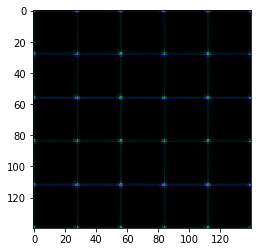

Epoch 1/1... Step 11/633.121875... Discriminator Loss: 1.7135... Generator Loss: 0.4045
Epoch 1/1... Step 12/633.121875... Discriminator Loss: 1.7857... Generator Loss: 0.5151
Epoch 1/1... Step 13/633.121875... Discriminator Loss: 1.9108... Generator Loss: 0.6015
Epoch 1/1... Step 14/633.121875... Discriminator Loss: 2.0226... Generator Loss: 0.3467
Epoch 1/1... Step 15/633.121875... Discriminator Loss: 2.1229... Generator Loss: 0.3285
Epoch 1/1... Step 16/633.121875... Discriminator Loss: 1.8982... Generator Loss: 0.4116
Epoch 1/1... Step 17/633.121875... Discriminator Loss: 2.1147... Generator Loss: 0.3243
Epoch 1/1... Step 18/633.121875... Discriminator Loss: 2.1810... Generator Loss: 0.2484
Epoch 1/1... Step 19/633.121875... Discriminator Loss: 1.7625... Generator Loss: 0.7465
Epoch 1/1... Step 20/633.121875... Discriminator Loss: 1.7015... Generator Loss: 0.4623


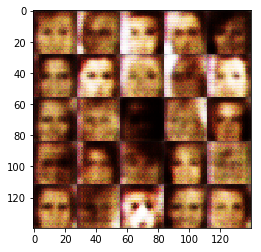

Epoch 1/1... Step 21/633.121875... Discriminator Loss: 1.9345... Generator Loss: 0.3719
Epoch 1/1... Step 22/633.121875... Discriminator Loss: 1.5598... Generator Loss: 0.5451
Epoch 1/1... Step 23/633.121875... Discriminator Loss: 2.1858... Generator Loss: 0.2900
Epoch 1/1... Step 24/633.121875... Discriminator Loss: 1.6212... Generator Loss: 0.5069
Epoch 1/1... Step 25/633.121875... Discriminator Loss: 1.6846... Generator Loss: 0.5173
Epoch 1/1... Step 26/633.121875... Discriminator Loss: 2.2208... Generator Loss: 0.2658
Epoch 1/1... Step 27/633.121875... Discriminator Loss: 1.8930... Generator Loss: 0.4123
Epoch 1/1... Step 28/633.121875... Discriminator Loss: 1.6923... Generator Loss: 0.4123
Epoch 1/1... Step 29/633.121875... Discriminator Loss: 1.7373... Generator Loss: 0.4776
Epoch 1/1... Step 30/633.121875... Discriminator Loss: 1.5418... Generator Loss: 0.5157


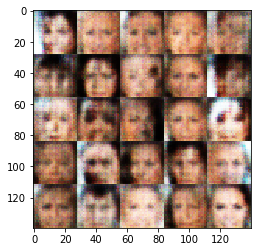

Epoch 1/1... Step 31/633.121875... Discriminator Loss: 1.5323... Generator Loss: 0.5934
Epoch 1/1... Step 32/633.121875... Discriminator Loss: 1.6952... Generator Loss: 0.4987
Epoch 1/1... Step 33/633.121875... Discriminator Loss: 1.7315... Generator Loss: 0.4248
Epoch 1/1... Step 34/633.121875... Discriminator Loss: 1.6987... Generator Loss: 0.4607
Epoch 1/1... Step 35/633.121875... Discriminator Loss: 1.6793... Generator Loss: 0.5306
Epoch 1/1... Step 36/633.121875... Discriminator Loss: 1.5917... Generator Loss: 0.5002
Epoch 1/1... Step 37/633.121875... Discriminator Loss: 1.6997... Generator Loss: 0.4683
Epoch 1/1... Step 38/633.121875... Discriminator Loss: 1.6463... Generator Loss: 0.5179
Epoch 1/1... Step 39/633.121875... Discriminator Loss: 1.6813... Generator Loss: 0.4961
Epoch 1/1... Step 40/633.121875... Discriminator Loss: 1.6086... Generator Loss: 0.5189


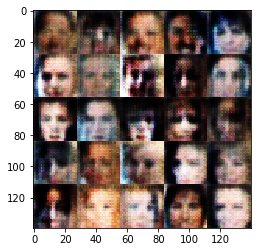

Epoch 1/1... Step 41/633.121875... Discriminator Loss: 1.6226... Generator Loss: 0.5823
Epoch 1/1... Step 42/633.121875... Discriminator Loss: 1.6464... Generator Loss: 0.5289
Epoch 1/1... Step 43/633.121875... Discriminator Loss: 1.5786... Generator Loss: 0.5019
Epoch 1/1... Step 44/633.121875... Discriminator Loss: 1.6143... Generator Loss: 0.5060
Epoch 1/1... Step 45/633.121875... Discriminator Loss: 1.6593... Generator Loss: 0.5083
Epoch 1/1... Step 46/633.121875... Discriminator Loss: 1.6748... Generator Loss: 0.4568
Epoch 1/1... Step 47/633.121875... Discriminator Loss: 1.7383... Generator Loss: 0.4393
Epoch 1/1... Step 48/633.121875... Discriminator Loss: 1.6351... Generator Loss: 0.4759
Epoch 1/1... Step 49/633.121875... Discriminator Loss: 1.6760... Generator Loss: 0.5359
Epoch 1/1... Step 50/633.121875... Discriminator Loss: 1.7378... Generator Loss: 0.5458


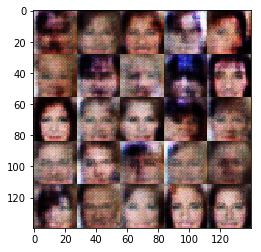

Epoch 1/1... Step 51/633.121875... Discriminator Loss: 1.5122... Generator Loss: 0.5741
Epoch 1/1... Step 52/633.121875... Discriminator Loss: 1.5171... Generator Loss: 0.6167
Epoch 1/1... Step 53/633.121875... Discriminator Loss: 1.7725... Generator Loss: 0.4401
Epoch 1/1... Step 54/633.121875... Discriminator Loss: 1.6214... Generator Loss: 0.5132
Epoch 1/1... Step 55/633.121875... Discriminator Loss: 1.5796... Generator Loss: 0.5135
Epoch 1/1... Step 56/633.121875... Discriminator Loss: 1.5658... Generator Loss: 0.5037
Epoch 1/1... Step 57/633.121875... Discriminator Loss: 1.5610... Generator Loss: 0.5114
Epoch 1/1... Step 58/633.121875... Discriminator Loss: 1.6106... Generator Loss: 0.5576
Epoch 1/1... Step 59/633.121875... Discriminator Loss: 1.6297... Generator Loss: 0.5203
Epoch 1/1... Step 60/633.121875... Discriminator Loss: 1.7445... Generator Loss: 0.4763


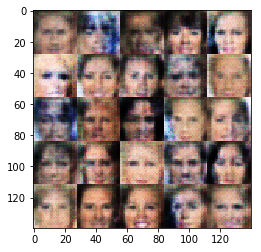

Epoch 1/1... Step 61/633.121875... Discriminator Loss: 1.5578... Generator Loss: 0.5345
Epoch 1/1... Step 62/633.121875... Discriminator Loss: 1.5419... Generator Loss: 0.5352
Epoch 1/1... Step 63/633.121875... Discriminator Loss: 1.5217... Generator Loss: 0.5941
Epoch 1/1... Step 64/633.121875... Discriminator Loss: 1.5773... Generator Loss: 0.4949
Epoch 1/1... Step 65/633.121875... Discriminator Loss: 1.5741... Generator Loss: 0.5397
Epoch 1/1... Step 66/633.121875... Discriminator Loss: 1.7566... Generator Loss: 0.4686
Epoch 1/1... Step 67/633.121875... Discriminator Loss: 1.5555... Generator Loss: 0.6241
Epoch 1/1... Step 68/633.121875... Discriminator Loss: 1.5821... Generator Loss: 0.5340
Epoch 1/1... Step 69/633.121875... Discriminator Loss: 1.4642... Generator Loss: 0.6056
Epoch 1/1... Step 70/633.121875... Discriminator Loss: 1.5521... Generator Loss: 0.5324


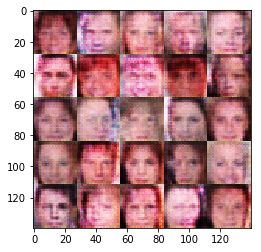

Epoch 1/1... Step 71/633.121875... Discriminator Loss: 1.5785... Generator Loss: 0.5773
Epoch 1/1... Step 72/633.121875... Discriminator Loss: 1.5655... Generator Loss: 0.5291
Epoch 1/1... Step 73/633.121875... Discriminator Loss: 1.6790... Generator Loss: 0.5019
Epoch 1/1... Step 74/633.121875... Discriminator Loss: 1.5990... Generator Loss: 0.5282
Epoch 1/1... Step 75/633.121875... Discriminator Loss: 1.6092... Generator Loss: 0.5519
Epoch 1/1... Step 76/633.121875... Discriminator Loss: 1.5351... Generator Loss: 0.5623
Epoch 1/1... Step 77/633.121875... Discriminator Loss: 1.5710... Generator Loss: 0.5500
Epoch 1/1... Step 78/633.121875... Discriminator Loss: 1.5835... Generator Loss: 0.4993
Epoch 1/1... Step 79/633.121875... Discriminator Loss: 1.6159... Generator Loss: 0.5112
Epoch 1/1... Step 80/633.121875... Discriminator Loss: 1.6832... Generator Loss: 0.4880


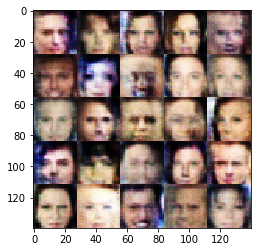

Epoch 1/1... Step 81/633.121875... Discriminator Loss: 1.6319... Generator Loss: 0.4940
Epoch 1/1... Step 82/633.121875... Discriminator Loss: 1.6207... Generator Loss: 0.5496
Epoch 1/1... Step 83/633.121875... Discriminator Loss: 1.5915... Generator Loss: 0.5108
Epoch 1/1... Step 84/633.121875... Discriminator Loss: 1.6175... Generator Loss: 0.5367
Epoch 1/1... Step 85/633.121875... Discriminator Loss: 1.4565... Generator Loss: 0.6124
Epoch 1/1... Step 86/633.121875... Discriminator Loss: 1.4997... Generator Loss: 0.6386
Epoch 1/1... Step 87/633.121875... Discriminator Loss: 1.6251... Generator Loss: 0.5340
Epoch 1/1... Step 88/633.121875... Discriminator Loss: 1.7500... Generator Loss: 0.4602
Epoch 1/1... Step 89/633.121875... Discriminator Loss: 1.4484... Generator Loss: 0.6176
Epoch 1/1... Step 90/633.121875... Discriminator Loss: 1.5513... Generator Loss: 0.5662


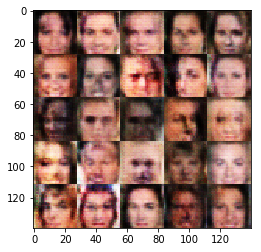

Epoch 1/1... Step 91/633.121875... Discriminator Loss: 1.5954... Generator Loss: 0.5450
Epoch 1/1... Step 92/633.121875... Discriminator Loss: 1.5309... Generator Loss: 0.5815
Epoch 1/1... Step 93/633.121875... Discriminator Loss: 1.5869... Generator Loss: 0.5345
Epoch 1/1... Step 94/633.121875... Discriminator Loss: 1.5236... Generator Loss: 0.6394
Epoch 1/1... Step 95/633.121875... Discriminator Loss: 1.6040... Generator Loss: 0.4958
Epoch 1/1... Step 96/633.121875... Discriminator Loss: 1.6100... Generator Loss: 0.5209
Epoch 1/1... Step 97/633.121875... Discriminator Loss: 1.6678... Generator Loss: 0.4898
Epoch 1/1... Step 98/633.121875... Discriminator Loss: 1.6538... Generator Loss: 0.4992
Epoch 1/1... Step 99/633.121875... Discriminator Loss: 1.6030... Generator Loss: 0.5221
Epoch 1/1... Step 100/633.121875... Discriminator Loss: 1.5173... Generator Loss: 0.6066


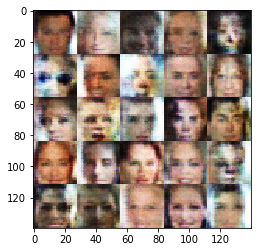

Epoch 1/1... Step 101/633.121875... Discriminator Loss: 1.4842... Generator Loss: 0.6336
Epoch 1/1... Step 102/633.121875... Discriminator Loss: 1.6631... Generator Loss: 0.5493
Epoch 1/1... Step 103/633.121875... Discriminator Loss: 1.5347... Generator Loss: 0.5692
Epoch 1/1... Step 104/633.121875... Discriminator Loss: 1.5078... Generator Loss: 0.6012
Epoch 1/1... Step 105/633.121875... Discriminator Loss: 1.6132... Generator Loss: 0.5346
Epoch 1/1... Step 106/633.121875... Discriminator Loss: 1.5800... Generator Loss: 0.5386
Epoch 1/1... Step 107/633.121875... Discriminator Loss: 1.5448... Generator Loss: 0.5890
Epoch 1/1... Step 108/633.121875... Discriminator Loss: 1.5971... Generator Loss: 0.5523
Epoch 1/1... Step 109/633.121875... Discriminator Loss: 1.4841... Generator Loss: 0.6115
Epoch 1/1... Step 110/633.121875... Discriminator Loss: 1.6204... Generator Loss: 0.5464


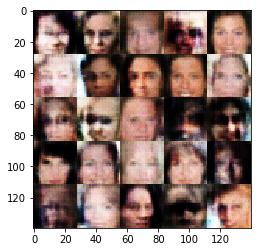

Epoch 1/1... Step 111/633.121875... Discriminator Loss: 1.5020... Generator Loss: 0.6060
Epoch 1/1... Step 112/633.121875... Discriminator Loss: 1.6047... Generator Loss: 0.5379
Epoch 1/1... Step 113/633.121875... Discriminator Loss: 1.5785... Generator Loss: 0.5527
Epoch 1/1... Step 114/633.121875... Discriminator Loss: 1.5788... Generator Loss: 0.5550
Epoch 1/1... Step 115/633.121875... Discriminator Loss: 1.4972... Generator Loss: 0.6538
Epoch 1/1... Step 116/633.121875... Discriminator Loss: 1.4067... Generator Loss: 0.6542
Epoch 1/1... Step 117/633.121875... Discriminator Loss: 1.6871... Generator Loss: 0.4995
Epoch 1/1... Step 118/633.121875... Discriminator Loss: 1.5120... Generator Loss: 0.5638
Epoch 1/1... Step 119/633.121875... Discriminator Loss: 1.5429... Generator Loss: 0.5859
Epoch 1/1... Step 120/633.121875... Discriminator Loss: 1.5141... Generator Loss: 0.5861


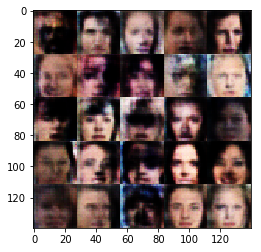

Epoch 1/1... Step 121/633.121875... Discriminator Loss: 1.5309... Generator Loss: 0.6547
Epoch 1/1... Step 122/633.121875... Discriminator Loss: 1.5020... Generator Loss: 0.5971
Epoch 1/1... Step 123/633.121875... Discriminator Loss: 1.5053... Generator Loss: 0.5855
Epoch 1/1... Step 124/633.121875... Discriminator Loss: 1.5238... Generator Loss: 0.6487
Epoch 1/1... Step 125/633.121875... Discriminator Loss: 1.6547... Generator Loss: 0.5211
Epoch 1/1... Step 126/633.121875... Discriminator Loss: 1.4940... Generator Loss: 0.6284
Epoch 1/1... Step 127/633.121875... Discriminator Loss: 1.4790... Generator Loss: 0.6036
Epoch 1/1... Step 128/633.121875... Discriminator Loss: 1.5324... Generator Loss: 0.6235
Epoch 1/1... Step 129/633.121875... Discriminator Loss: 1.4736... Generator Loss: 0.6476
Epoch 1/1... Step 130/633.121875... Discriminator Loss: 1.6059... Generator Loss: 0.5509


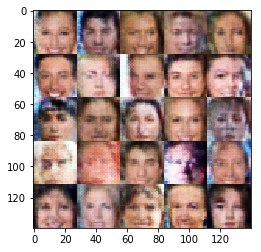

Epoch 1/1... Step 131/633.121875... Discriminator Loss: 1.5691... Generator Loss: 0.5516
Epoch 1/1... Step 132/633.121875... Discriminator Loss: 1.5193... Generator Loss: 0.6341
Epoch 1/1... Step 133/633.121875... Discriminator Loss: 1.4748... Generator Loss: 0.6293
Epoch 1/1... Step 134/633.121875... Discriminator Loss: 1.5280... Generator Loss: 0.6059
Epoch 1/1... Step 135/633.121875... Discriminator Loss: 1.5300... Generator Loss: 0.5925
Epoch 1/1... Step 136/633.121875... Discriminator Loss: 1.5222... Generator Loss: 0.6070
Epoch 1/1... Step 137/633.121875... Discriminator Loss: 1.5269... Generator Loss: 0.6120
Epoch 1/1... Step 138/633.121875... Discriminator Loss: 1.5501... Generator Loss: 0.5506
Epoch 1/1... Step 139/633.121875... Discriminator Loss: 1.5566... Generator Loss: 0.5777
Epoch 1/1... Step 140/633.121875... Discriminator Loss: 1.5247... Generator Loss: 0.6050


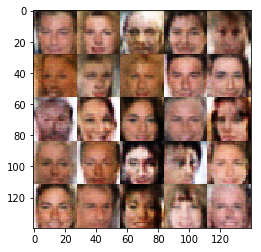

Epoch 1/1... Step 141/633.121875... Discriminator Loss: 1.5474... Generator Loss: 0.5751
Epoch 1/1... Step 142/633.121875... Discriminator Loss: 1.5148... Generator Loss: 0.5814
Epoch 1/1... Step 143/633.121875... Discriminator Loss: 1.5385... Generator Loss: 0.5978
Epoch 1/1... Step 144/633.121875... Discriminator Loss: 1.4839... Generator Loss: 0.6209
Epoch 1/1... Step 145/633.121875... Discriminator Loss: 1.6807... Generator Loss: 0.5284
Epoch 1/1... Step 146/633.121875... Discriminator Loss: 1.5026... Generator Loss: 0.5876
Epoch 1/1... Step 147/633.121875... Discriminator Loss: 1.5738... Generator Loss: 0.5810
Epoch 1/1... Step 148/633.121875... Discriminator Loss: 1.4370... Generator Loss: 0.6894
Epoch 1/1... Step 149/633.121875... Discriminator Loss: 1.5238... Generator Loss: 0.5915
Epoch 1/1... Step 150/633.121875... Discriminator Loss: 1.3985... Generator Loss: 0.6891


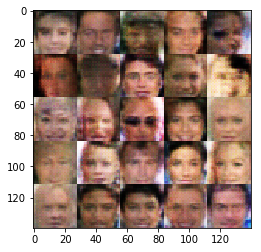

Epoch 1/1... Step 151/633.121875... Discriminator Loss: 1.5708... Generator Loss: 0.5637
Epoch 1/1... Step 152/633.121875... Discriminator Loss: 1.4801... Generator Loss: 0.6283
Epoch 1/1... Step 153/633.121875... Discriminator Loss: 1.5186... Generator Loss: 0.6074
Epoch 1/1... Step 154/633.121875... Discriminator Loss: 1.6516... Generator Loss: 0.5131
Epoch 1/1... Step 155/633.121875... Discriminator Loss: 1.5104... Generator Loss: 0.5919
Epoch 1/1... Step 156/633.121875... Discriminator Loss: 1.4837... Generator Loss: 0.6340
Epoch 1/1... Step 157/633.121875... Discriminator Loss: 1.4803... Generator Loss: 0.6519
Epoch 1/1... Step 158/633.121875... Discriminator Loss: 1.4850... Generator Loss: 0.6403
Epoch 1/1... Step 159/633.121875... Discriminator Loss: 1.4981... Generator Loss: 0.6214
Epoch 1/1... Step 160/633.121875... Discriminator Loss: 1.4729... Generator Loss: 0.6408


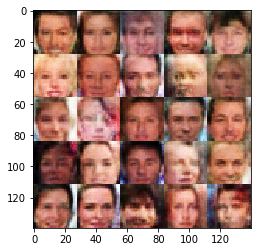

Epoch 1/1... Step 161/633.121875... Discriminator Loss: 1.5039... Generator Loss: 0.6365
Epoch 1/1... Step 162/633.121875... Discriminator Loss: 1.5036... Generator Loss: 0.6341
Epoch 1/1... Step 163/633.121875... Discriminator Loss: 1.4618... Generator Loss: 0.6777
Epoch 1/1... Step 164/633.121875... Discriminator Loss: 1.4657... Generator Loss: 0.6516
Epoch 1/1... Step 165/633.121875... Discriminator Loss: 1.4909... Generator Loss: 0.6221
Epoch 1/1... Step 166/633.121875... Discriminator Loss: 1.5033... Generator Loss: 0.6505
Epoch 1/1... Step 167/633.121875... Discriminator Loss: 1.4100... Generator Loss: 0.7039
Epoch 1/1... Step 168/633.121875... Discriminator Loss: 1.4762... Generator Loss: 0.6677
Epoch 1/1... Step 169/633.121875... Discriminator Loss: 1.4843... Generator Loss: 0.6672
Epoch 1/1... Step 170/633.121875... Discriminator Loss: 1.4809... Generator Loss: 0.6322


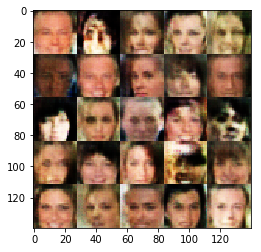

Epoch 1/1... Step 171/633.121875... Discriminator Loss: 1.4757... Generator Loss: 0.6502
Epoch 1/1... Step 172/633.121875... Discriminator Loss: 1.5054... Generator Loss: 0.6420
Epoch 1/1... Step 173/633.121875... Discriminator Loss: 1.4465... Generator Loss: 0.6835
Epoch 1/1... Step 174/633.121875... Discriminator Loss: 1.5198... Generator Loss: 0.6200
Epoch 1/1... Step 175/633.121875... Discriminator Loss: 1.5276... Generator Loss: 0.5755
Epoch 1/1... Step 176/633.121875... Discriminator Loss: 1.4504... Generator Loss: 0.7007
Epoch 1/1... Step 177/633.121875... Discriminator Loss: 1.4491... Generator Loss: 0.6978
Epoch 1/1... Step 178/633.121875... Discriminator Loss: 1.4967... Generator Loss: 0.6126
Epoch 1/1... Step 179/633.121875... Discriminator Loss: 1.5001... Generator Loss: 0.6324
Epoch 1/1... Step 180/633.121875... Discriminator Loss: 1.5332... Generator Loss: 0.5900


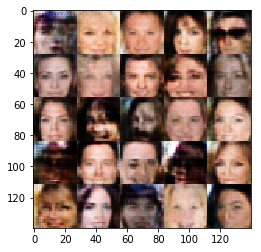

Epoch 1/1... Step 181/633.121875... Discriminator Loss: 1.3762... Generator Loss: 0.7254
Epoch 1/1... Step 182/633.121875... Discriminator Loss: 1.5143... Generator Loss: 0.6547
Epoch 1/1... Step 183/633.121875... Discriminator Loss: 1.4049... Generator Loss: 0.7241
Epoch 1/1... Step 184/633.121875... Discriminator Loss: 1.4494... Generator Loss: 0.6520
Epoch 1/1... Step 185/633.121875... Discriminator Loss: 1.4110... Generator Loss: 0.7015
Epoch 1/1... Step 186/633.121875... Discriminator Loss: 1.4353... Generator Loss: 0.6938
Epoch 1/1... Step 187/633.121875... Discriminator Loss: 1.4595... Generator Loss: 0.6692
Epoch 1/1... Step 188/633.121875... Discriminator Loss: 1.5486... Generator Loss: 0.5945
Epoch 1/1... Step 189/633.121875... Discriminator Loss: 1.4729... Generator Loss: 0.6623
Epoch 1/1... Step 190/633.121875... Discriminator Loss: 1.4594... Generator Loss: 0.6699


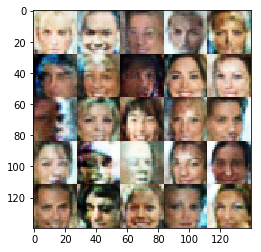

Epoch 1/1... Step 191/633.121875... Discriminator Loss: 1.4676... Generator Loss: 0.6530
Epoch 1/1... Step 192/633.121875... Discriminator Loss: 1.4592... Generator Loss: 0.6723
Epoch 1/1... Step 193/633.121875... Discriminator Loss: 1.4473... Generator Loss: 0.6382
Epoch 1/1... Step 194/633.121875... Discriminator Loss: 1.4474... Generator Loss: 0.6668
Epoch 1/1... Step 195/633.121875... Discriminator Loss: 1.4684... Generator Loss: 0.6696
Epoch 1/1... Step 196/633.121875... Discriminator Loss: 1.4803... Generator Loss: 0.6559
Epoch 1/1... Step 197/633.121875... Discriminator Loss: 1.4540... Generator Loss: 0.6702
Epoch 1/1... Step 198/633.121875... Discriminator Loss: 1.5119... Generator Loss: 0.6490
Epoch 1/1... Step 199/633.121875... Discriminator Loss: 1.4752... Generator Loss: 0.6631
Epoch 1/1... Step 200/633.121875... Discriminator Loss: 1.4369... Generator Loss: 0.6408


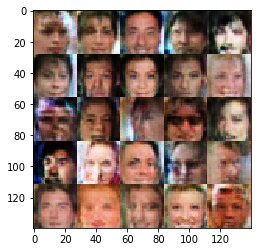

Epoch 1/1... Step 201/633.121875... Discriminator Loss: 1.4902... Generator Loss: 0.6281
Epoch 1/1... Step 202/633.121875... Discriminator Loss: 1.4668... Generator Loss: 0.6640
Epoch 1/1... Step 203/633.121875... Discriminator Loss: 1.5010... Generator Loss: 0.6308
Epoch 1/1... Step 204/633.121875... Discriminator Loss: 1.4822... Generator Loss: 0.6427
Epoch 1/1... Step 205/633.121875... Discriminator Loss: 1.5089... Generator Loss: 0.6297
Epoch 1/1... Step 206/633.121875... Discriminator Loss: 1.4623... Generator Loss: 0.6648
Epoch 1/1... Step 207/633.121875... Discriminator Loss: 1.4577... Generator Loss: 0.6535
Epoch 1/1... Step 208/633.121875... Discriminator Loss: 1.4274... Generator Loss: 0.6948
Epoch 1/1... Step 209/633.121875... Discriminator Loss: 1.4934... Generator Loss: 0.6552
Epoch 1/1... Step 210/633.121875... Discriminator Loss: 1.4912... Generator Loss: 0.6421


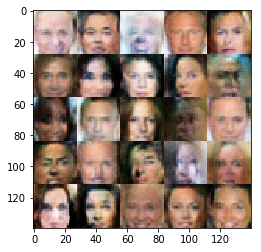

Epoch 1/1... Step 211/633.121875... Discriminator Loss: 1.4851... Generator Loss: 0.6219
Epoch 1/1... Step 212/633.121875... Discriminator Loss: 1.5375... Generator Loss: 0.6112
Epoch 1/1... Step 213/633.121875... Discriminator Loss: 1.4312... Generator Loss: 0.6804
Epoch 1/1... Step 214/633.121875... Discriminator Loss: 1.4809... Generator Loss: 0.6571
Epoch 1/1... Step 215/633.121875... Discriminator Loss: 1.4398... Generator Loss: 0.7011
Epoch 1/1... Step 216/633.121875... Discriminator Loss: 1.4498... Generator Loss: 0.6755
Epoch 1/1... Step 217/633.121875... Discriminator Loss: 1.4315... Generator Loss: 0.6929
Epoch 1/1... Step 218/633.121875... Discriminator Loss: 1.4833... Generator Loss: 0.6300
Epoch 1/1... Step 219/633.121875... Discriminator Loss: 1.4877... Generator Loss: 0.6549
Epoch 1/1... Step 220/633.121875... Discriminator Loss: 1.4322... Generator Loss: 0.6930


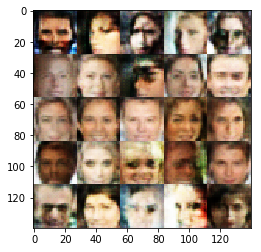

Epoch 1/1... Step 221/633.121875... Discriminator Loss: 1.5145... Generator Loss: 0.6190
Epoch 1/1... Step 222/633.121875... Discriminator Loss: 1.4863... Generator Loss: 0.6481
Epoch 1/1... Step 223/633.121875... Discriminator Loss: 1.4476... Generator Loss: 0.6907
Epoch 1/1... Step 224/633.121875... Discriminator Loss: 1.4637... Generator Loss: 0.6670
Epoch 1/1... Step 225/633.121875... Discriminator Loss: 1.4643... Generator Loss: 0.6714
Epoch 1/1... Step 226/633.121875... Discriminator Loss: 1.4670... Generator Loss: 0.6494
Epoch 1/1... Step 227/633.121875... Discriminator Loss: 1.4279... Generator Loss: 0.6867
Epoch 1/1... Step 228/633.121875... Discriminator Loss: 1.4737... Generator Loss: 0.6653
Epoch 1/1... Step 229/633.121875... Discriminator Loss: 1.4768... Generator Loss: 0.6517
Epoch 1/1... Step 230/633.121875... Discriminator Loss: 1.4888... Generator Loss: 0.6364


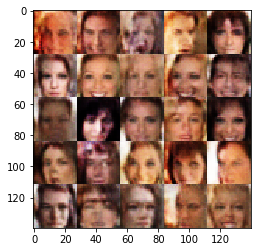

Epoch 1/1... Step 231/633.121875... Discriminator Loss: 1.4366... Generator Loss: 0.6753
Epoch 1/1... Step 232/633.121875... Discriminator Loss: 1.4682... Generator Loss: 0.6729
Epoch 1/1... Step 233/633.121875... Discriminator Loss: 1.4427... Generator Loss: 0.6904
Epoch 1/1... Step 234/633.121875... Discriminator Loss: 1.4655... Generator Loss: 0.6709
Epoch 1/1... Step 235/633.121875... Discriminator Loss: 1.4569... Generator Loss: 0.6662
Epoch 1/1... Step 236/633.121875... Discriminator Loss: 1.4526... Generator Loss: 0.6577
Epoch 1/1... Step 237/633.121875... Discriminator Loss: 1.4619... Generator Loss: 0.6703
Epoch 1/1... Step 238/633.121875... Discriminator Loss: 1.4089... Generator Loss: 0.6925
Epoch 1/1... Step 239/633.121875... Discriminator Loss: 1.4604... Generator Loss: 0.6936
Epoch 1/1... Step 240/633.121875... Discriminator Loss: 1.3937... Generator Loss: 0.7282


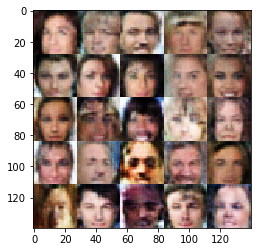

Epoch 1/1... Step 241/633.121875... Discriminator Loss: 1.3879... Generator Loss: 0.7368
Epoch 1/1... Step 242/633.121875... Discriminator Loss: 1.4221... Generator Loss: 0.7203
Epoch 1/1... Step 243/633.121875... Discriminator Loss: 1.4482... Generator Loss: 0.6836
Epoch 1/1... Step 244/633.121875... Discriminator Loss: 1.4654... Generator Loss: 0.6653
Epoch 1/1... Step 245/633.121875... Discriminator Loss: 1.4935... Generator Loss: 0.6895
Epoch 1/1... Step 246/633.121875... Discriminator Loss: 1.4708... Generator Loss: 0.6799
Epoch 1/1... Step 247/633.121875... Discriminator Loss: 1.4403... Generator Loss: 0.6941
Epoch 1/1... Step 248/633.121875... Discriminator Loss: 1.4380... Generator Loss: 0.6923
Epoch 1/1... Step 249/633.121875... Discriminator Loss: 1.5260... Generator Loss: 0.6387
Epoch 1/1... Step 250/633.121875... Discriminator Loss: 1.4641... Generator Loss: 0.6910


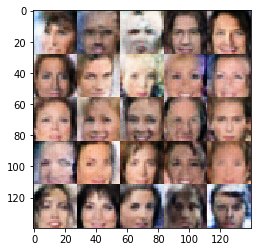

Epoch 1/1... Step 251/633.121875... Discriminator Loss: 1.4415... Generator Loss: 0.6782
Epoch 1/1... Step 252/633.121875... Discriminator Loss: 1.4370... Generator Loss: 0.6991
Epoch 1/1... Step 253/633.121875... Discriminator Loss: 1.4596... Generator Loss: 0.6712
Epoch 1/1... Step 254/633.121875... Discriminator Loss: 1.4307... Generator Loss: 0.7107
Epoch 1/1... Step 255/633.121875... Discriminator Loss: 1.4404... Generator Loss: 0.6897
Epoch 1/1... Step 256/633.121875... Discriminator Loss: 1.4251... Generator Loss: 0.6972
Epoch 1/1... Step 257/633.121875... Discriminator Loss: 1.3987... Generator Loss: 0.7262
Epoch 1/1... Step 258/633.121875... Discriminator Loss: 1.4724... Generator Loss: 0.6932
Epoch 1/1... Step 259/633.121875... Discriminator Loss: 1.4392... Generator Loss: 0.6636
Epoch 1/1... Step 260/633.121875... Discriminator Loss: 1.4524... Generator Loss: 0.6915


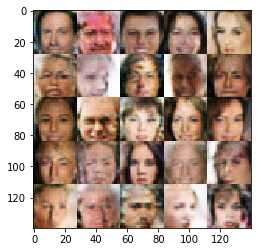

Epoch 1/1... Step 261/633.121875... Discriminator Loss: 1.4151... Generator Loss: 0.7301
Epoch 1/1... Step 262/633.121875... Discriminator Loss: 1.4147... Generator Loss: 0.7494
Epoch 1/1... Step 263/633.121875... Discriminator Loss: 1.4020... Generator Loss: 0.7047
Epoch 1/1... Step 264/633.121875... Discriminator Loss: 1.4610... Generator Loss: 0.6619
Epoch 1/1... Step 265/633.121875... Discriminator Loss: 1.4409... Generator Loss: 0.6995
Epoch 1/1... Step 266/633.121875... Discriminator Loss: 1.4614... Generator Loss: 0.6744
Epoch 1/1... Step 267/633.121875... Discriminator Loss: 1.4260... Generator Loss: 0.7044
Epoch 1/1... Step 268/633.121875... Discriminator Loss: 1.5008... Generator Loss: 0.6535
Epoch 1/1... Step 269/633.121875... Discriminator Loss: 1.4941... Generator Loss: 0.6537
Epoch 1/1... Step 270/633.121875... Discriminator Loss: 1.4563... Generator Loss: 0.6796


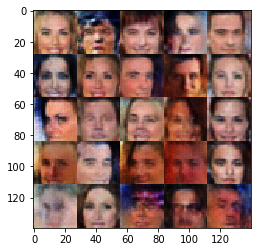

Epoch 1/1... Step 271/633.121875... Discriminator Loss: 1.4687... Generator Loss: 0.6805
Epoch 1/1... Step 272/633.121875... Discriminator Loss: 1.4382... Generator Loss: 0.7104
Epoch 1/1... Step 273/633.121875... Discriminator Loss: 1.4696... Generator Loss: 0.6743
Epoch 1/1... Step 274/633.121875... Discriminator Loss: 1.5097... Generator Loss: 0.6288
Epoch 1/1... Step 275/633.121875... Discriminator Loss: 1.4174... Generator Loss: 0.7186
Epoch 1/1... Step 276/633.121875... Discriminator Loss: 1.4712... Generator Loss: 0.6797
Epoch 1/1... Step 277/633.121875... Discriminator Loss: 1.4315... Generator Loss: 0.7050
Epoch 1/1... Step 278/633.121875... Discriminator Loss: 1.4537... Generator Loss: 0.7089
Epoch 1/1... Step 279/633.121875... Discriminator Loss: 1.4484... Generator Loss: 0.6950
Epoch 1/1... Step 280/633.121875... Discriminator Loss: 1.4600... Generator Loss: 0.6838


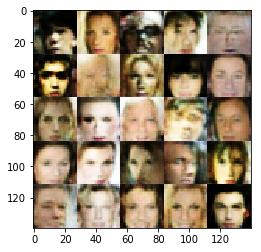

Epoch 1/1... Step 281/633.121875... Discriminator Loss: 1.4361... Generator Loss: 0.6871
Epoch 1/1... Step 282/633.121875... Discriminator Loss: 1.4498... Generator Loss: 0.6853
Epoch 1/1... Step 283/633.121875... Discriminator Loss: 1.4411... Generator Loss: 0.6965
Epoch 1/1... Step 284/633.121875... Discriminator Loss: 1.4532... Generator Loss: 0.6969
Epoch 1/1... Step 285/633.121875... Discriminator Loss: 1.5228... Generator Loss: 0.6136
Epoch 1/1... Step 286/633.121875... Discriminator Loss: 1.4804... Generator Loss: 0.6585
Epoch 1/1... Step 287/633.121875... Discriminator Loss: 1.4430... Generator Loss: 0.6818
Epoch 1/1... Step 288/633.121875... Discriminator Loss: 1.5029... Generator Loss: 0.6370
Epoch 1/1... Step 289/633.121875... Discriminator Loss: 1.4881... Generator Loss: 0.6598
Epoch 1/1... Step 290/633.121875... Discriminator Loss: 1.4498... Generator Loss: 0.6790


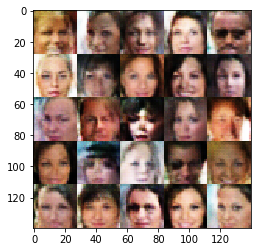

Epoch 1/1... Step 291/633.121875... Discriminator Loss: 1.4806... Generator Loss: 0.6759
Epoch 1/1... Step 292/633.121875... Discriminator Loss: 1.4741... Generator Loss: 0.6953
Epoch 1/1... Step 293/633.121875... Discriminator Loss: 1.3941... Generator Loss: 0.7384
Epoch 1/1... Step 294/633.121875... Discriminator Loss: 1.4154... Generator Loss: 0.7132
Epoch 1/1... Step 295/633.121875... Discriminator Loss: 1.4074... Generator Loss: 0.7162
Epoch 1/1... Step 296/633.121875... Discriminator Loss: 1.4201... Generator Loss: 0.7117
Epoch 1/1... Step 297/633.121875... Discriminator Loss: 1.3966... Generator Loss: 0.7350
Epoch 1/1... Step 298/633.121875... Discriminator Loss: 1.4267... Generator Loss: 0.6942
Epoch 1/1... Step 299/633.121875... Discriminator Loss: 1.4251... Generator Loss: 0.7224
Epoch 1/1... Step 300/633.121875... Discriminator Loss: 1.4903... Generator Loss: 0.6790


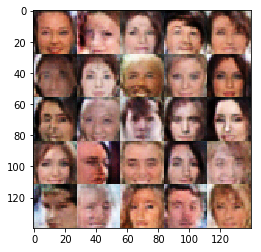

Epoch 1/1... Step 301/633.121875... Discriminator Loss: 1.4332... Generator Loss: 0.7127
Epoch 1/1... Step 302/633.121875... Discriminator Loss: 1.4263... Generator Loss: 0.7152
Epoch 1/1... Step 303/633.121875... Discriminator Loss: 1.4182... Generator Loss: 0.7171
Epoch 1/1... Step 304/633.121875... Discriminator Loss: 1.4231... Generator Loss: 0.7150
Epoch 1/1... Step 305/633.121875... Discriminator Loss: 1.4777... Generator Loss: 0.6844
Epoch 1/1... Step 306/633.121875... Discriminator Loss: 1.4402... Generator Loss: 0.6909
Epoch 1/1... Step 307/633.121875... Discriminator Loss: 1.4538... Generator Loss: 0.6973
Epoch 1/1... Step 308/633.121875... Discriminator Loss: 1.4515... Generator Loss: 0.6948
Epoch 1/1... Step 309/633.121875... Discriminator Loss: 1.4598... Generator Loss: 0.6793
Epoch 1/1... Step 310/633.121875... Discriminator Loss: 1.4566... Generator Loss: 0.7017


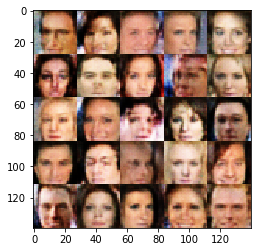

Epoch 1/1... Step 311/633.121875... Discriminator Loss: 1.4298... Generator Loss: 0.7171
Epoch 1/1... Step 312/633.121875... Discriminator Loss: 1.4525... Generator Loss: 0.6996
Epoch 1/1... Step 313/633.121875... Discriminator Loss: 1.4745... Generator Loss: 0.6736
Epoch 1/1... Step 314/633.121875... Discriminator Loss: 1.4181... Generator Loss: 0.7067
Epoch 1/1... Step 315/633.121875... Discriminator Loss: 1.4688... Generator Loss: 0.6803
Epoch 1/1... Step 316/633.121875... Discriminator Loss: 1.4503... Generator Loss: 0.6827
Epoch 1/1... Step 317/633.121875... Discriminator Loss: 1.4595... Generator Loss: 0.6842
Epoch 1/1... Step 318/633.121875... Discriminator Loss: 1.4587... Generator Loss: 0.6690
Epoch 1/1... Step 319/633.121875... Discriminator Loss: 1.4181... Generator Loss: 0.7179
Epoch 1/1... Step 320/633.121875... Discriminator Loss: 1.5288... Generator Loss: 0.6319


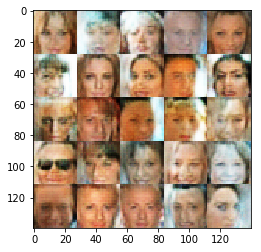

Epoch 1/1... Step 321/633.121875... Discriminator Loss: 1.4579... Generator Loss: 0.6980
Epoch 1/1... Step 322/633.121875... Discriminator Loss: 1.4606... Generator Loss: 0.6888
Epoch 1/1... Step 323/633.121875... Discriminator Loss: 1.4070... Generator Loss: 0.7292
Epoch 1/1... Step 324/633.121875... Discriminator Loss: 1.4265... Generator Loss: 0.7113
Epoch 1/1... Step 325/633.121875... Discriminator Loss: 1.4079... Generator Loss: 0.7302
Epoch 1/1... Step 326/633.121875... Discriminator Loss: 1.4366... Generator Loss: 0.7070
Epoch 1/1... Step 327/633.121875... Discriminator Loss: 1.4393... Generator Loss: 0.6974
Epoch 1/1... Step 328/633.121875... Discriminator Loss: 1.4426... Generator Loss: 0.7063
Epoch 1/1... Step 329/633.121875... Discriminator Loss: 1.4421... Generator Loss: 0.6910
Epoch 1/1... Step 330/633.121875... Discriminator Loss: 1.4294... Generator Loss: 0.7284


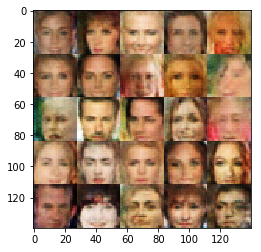

Epoch 1/1... Step 331/633.121875... Discriminator Loss: 1.4249... Generator Loss: 0.7078
Epoch 1/1... Step 332/633.121875... Discriminator Loss: 1.4496... Generator Loss: 0.7008
Epoch 1/1... Step 333/633.121875... Discriminator Loss: 1.4748... Generator Loss: 0.6848
Epoch 1/1... Step 334/633.121875... Discriminator Loss: 1.4249... Generator Loss: 0.7198
Epoch 1/1... Step 335/633.121875... Discriminator Loss: 1.4701... Generator Loss: 0.6806
Epoch 1/1... Step 336/633.121875... Discriminator Loss: 1.4346... Generator Loss: 0.7188
Epoch 1/1... Step 337/633.121875... Discriminator Loss: 1.4748... Generator Loss: 0.6636
Epoch 1/1... Step 338/633.121875... Discriminator Loss: 1.4264... Generator Loss: 0.7131
Epoch 1/1... Step 339/633.121875... Discriminator Loss: 1.4392... Generator Loss: 0.6974
Epoch 1/1... Step 340/633.121875... Discriminator Loss: 1.4350... Generator Loss: 0.7137


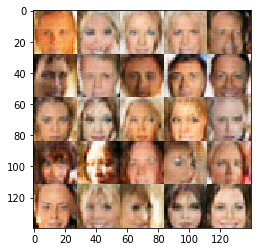

Epoch 1/1... Step 341/633.121875... Discriminator Loss: 1.4395... Generator Loss: 0.7374
Epoch 1/1... Step 342/633.121875... Discriminator Loss: 1.4239... Generator Loss: 0.7352
Epoch 1/1... Step 343/633.121875... Discriminator Loss: 1.4246... Generator Loss: 0.7225
Epoch 1/1... Step 344/633.121875... Discriminator Loss: 1.4444... Generator Loss: 0.6946
Epoch 1/1... Step 345/633.121875... Discriminator Loss: 1.4051... Generator Loss: 0.7132
Epoch 1/1... Step 346/633.121875... Discriminator Loss: 1.4245... Generator Loss: 0.7198
Epoch 1/1... Step 347/633.121875... Discriminator Loss: 1.4011... Generator Loss: 0.7263
Epoch 1/1... Step 348/633.121875... Discriminator Loss: 1.4113... Generator Loss: 0.7201
Epoch 1/1... Step 349/633.121875... Discriminator Loss: 1.4229... Generator Loss: 0.7189
Epoch 1/1... Step 350/633.121875... Discriminator Loss: 1.4182... Generator Loss: 0.7365


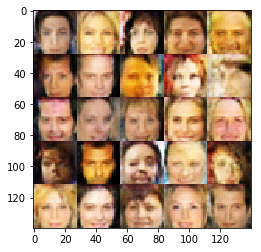

Epoch 1/1... Step 351/633.121875... Discriminator Loss: 1.4161... Generator Loss: 0.7264
Epoch 1/1... Step 352/633.121875... Discriminator Loss: 1.4263... Generator Loss: 0.7229
Epoch 1/1... Step 353/633.121875... Discriminator Loss: 1.4136... Generator Loss: 0.7356
Epoch 1/1... Step 354/633.121875... Discriminator Loss: 1.4645... Generator Loss: 0.6740
Epoch 1/1... Step 355/633.121875... Discriminator Loss: 1.4105... Generator Loss: 0.7430
Epoch 1/1... Step 356/633.121875... Discriminator Loss: 1.4433... Generator Loss: 0.7051
Epoch 1/1... Step 357/633.121875... Discriminator Loss: 1.4773... Generator Loss: 0.6508
Epoch 1/1... Step 358/633.121875... Discriminator Loss: 1.4561... Generator Loss: 0.6889
Epoch 1/1... Step 359/633.121875... Discriminator Loss: 1.4264... Generator Loss: 0.7288
Epoch 1/1... Step 360/633.121875... Discriminator Loss: 1.4317... Generator Loss: 0.7194


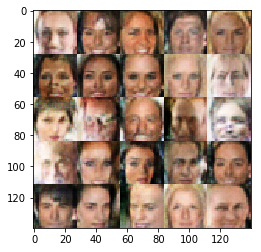

Epoch 1/1... Step 361/633.121875... Discriminator Loss: 1.4027... Generator Loss: 0.7210
Epoch 1/1... Step 362/633.121875... Discriminator Loss: 1.4430... Generator Loss: 0.7097
Epoch 1/1... Step 363/633.121875... Discriminator Loss: 1.4087... Generator Loss: 0.7400
Epoch 1/1... Step 364/633.121875... Discriminator Loss: 1.4240... Generator Loss: 0.7250
Epoch 1/1... Step 365/633.121875... Discriminator Loss: 1.4190... Generator Loss: 0.7240
Epoch 1/1... Step 366/633.121875... Discriminator Loss: 1.4270... Generator Loss: 0.7326
Epoch 1/1... Step 367/633.121875... Discriminator Loss: 1.4598... Generator Loss: 0.6923
Epoch 1/1... Step 368/633.121875... Discriminator Loss: 1.4588... Generator Loss: 0.7003
Epoch 1/1... Step 369/633.121875... Discriminator Loss: 1.4337... Generator Loss: 0.7106
Epoch 1/1... Step 370/633.121875... Discriminator Loss: 1.4274... Generator Loss: 0.6990


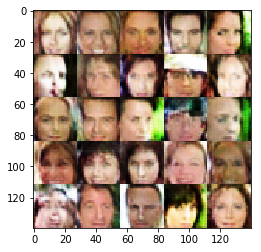

Epoch 1/1... Step 371/633.121875... Discriminator Loss: 1.4322... Generator Loss: 0.7213
Epoch 1/1... Step 372/633.121875... Discriminator Loss: 1.4243... Generator Loss: 0.7218
Epoch 1/1... Step 373/633.121875... Discriminator Loss: 1.4304... Generator Loss: 0.7242
Epoch 1/1... Step 374/633.121875... Discriminator Loss: 1.4110... Generator Loss: 0.7562
Epoch 1/1... Step 375/633.121875... Discriminator Loss: 1.4126... Generator Loss: 0.7286
Epoch 1/1... Step 376/633.121875... Discriminator Loss: 1.3971... Generator Loss: 0.7427
Epoch 1/1... Step 377/633.121875... Discriminator Loss: 1.4350... Generator Loss: 0.7129
Epoch 1/1... Step 378/633.121875... Discriminator Loss: 1.4307... Generator Loss: 0.7093
Epoch 1/1... Step 379/633.121875... Discriminator Loss: 1.4415... Generator Loss: 0.7144
Epoch 1/1... Step 380/633.121875... Discriminator Loss: 1.4038... Generator Loss: 0.7585


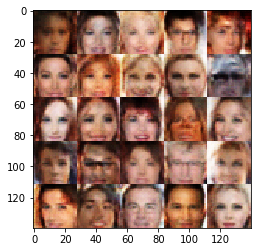

Epoch 1/1... Step 381/633.121875... Discriminator Loss: 1.4043... Generator Loss: 0.7368
Epoch 1/1... Step 382/633.121875... Discriminator Loss: 1.4111... Generator Loss: 0.7398
Epoch 1/1... Step 383/633.121875... Discriminator Loss: 1.4161... Generator Loss: 0.7304
Epoch 1/1... Step 384/633.121875... Discriminator Loss: 1.4347... Generator Loss: 0.6955
Epoch 1/1... Step 385/633.121875... Discriminator Loss: 1.4172... Generator Loss: 0.7292
Epoch 1/1... Step 386/633.121875... Discriminator Loss: 1.3925... Generator Loss: 0.7468
Epoch 1/1... Step 387/633.121875... Discriminator Loss: 1.4472... Generator Loss: 0.7181
Epoch 1/1... Step 388/633.121875... Discriminator Loss: 1.4283... Generator Loss: 0.7278
Epoch 1/1... Step 389/633.121875... Discriminator Loss: 1.3990... Generator Loss: 0.7398
Epoch 1/1... Step 390/633.121875... Discriminator Loss: 1.4571... Generator Loss: 0.7220


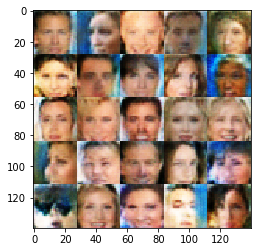

Epoch 1/1... Step 391/633.121875... Discriminator Loss: 1.4362... Generator Loss: 0.7109
Epoch 1/1... Step 392/633.121875... Discriminator Loss: 1.4365... Generator Loss: 0.7185
Epoch 1/1... Step 393/633.121875... Discriminator Loss: 1.4317... Generator Loss: 0.7191
Epoch 1/1... Step 394/633.121875... Discriminator Loss: 1.4286... Generator Loss: 0.7171
Epoch 1/1... Step 395/633.121875... Discriminator Loss: 1.4512... Generator Loss: 0.7081
Epoch 1/1... Step 396/633.121875... Discriminator Loss: 1.4459... Generator Loss: 0.7126
Epoch 1/1... Step 397/633.121875... Discriminator Loss: 1.3856... Generator Loss: 0.7626
Epoch 1/1... Step 398/633.121875... Discriminator Loss: 1.4412... Generator Loss: 0.7056
Epoch 1/1... Step 399/633.121875... Discriminator Loss: 1.4130... Generator Loss: 0.7273
Epoch 1/1... Step 400/633.121875... Discriminator Loss: 1.4146... Generator Loss: 0.7249


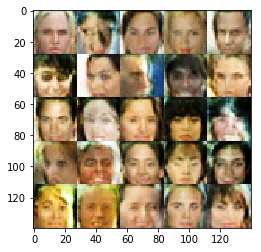

Epoch 1/1... Step 401/633.121875... Discriminator Loss: 1.4422... Generator Loss: 0.7036
Epoch 1/1... Step 402/633.121875... Discriminator Loss: 1.4045... Generator Loss: 0.7432
Epoch 1/1... Step 403/633.121875... Discriminator Loss: 1.4970... Generator Loss: 0.6905
Epoch 1/1... Step 404/633.121875... Discriminator Loss: 1.4202... Generator Loss: 0.7389
Epoch 1/1... Step 405/633.121875... Discriminator Loss: 1.4079... Generator Loss: 0.7339
Epoch 1/1... Step 406/633.121875... Discriminator Loss: 1.4361... Generator Loss: 0.7180
Epoch 1/1... Step 407/633.121875... Discriminator Loss: 1.4065... Generator Loss: 0.7429
Epoch 1/1... Step 408/633.121875... Discriminator Loss: 1.3956... Generator Loss: 0.7622
Epoch 1/1... Step 409/633.121875... Discriminator Loss: 1.4112... Generator Loss: 0.7284
Epoch 1/1... Step 410/633.121875... Discriminator Loss: 1.4265... Generator Loss: 0.7215


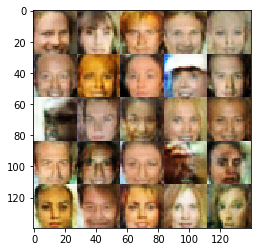

Epoch 1/1... Step 411/633.121875... Discriminator Loss: 1.4118... Generator Loss: 0.7291
Epoch 1/1... Step 412/633.121875... Discriminator Loss: 1.4465... Generator Loss: 0.7063
Epoch 1/1... Step 413/633.121875... Discriminator Loss: 1.4266... Generator Loss: 0.7332
Epoch 1/1... Step 414/633.121875... Discriminator Loss: 1.4419... Generator Loss: 0.7191
Epoch 1/1... Step 415/633.121875... Discriminator Loss: 1.4166... Generator Loss: 0.7356
Epoch 1/1... Step 416/633.121875... Discriminator Loss: 1.4338... Generator Loss: 0.7168
Epoch 1/1... Step 417/633.121875... Discriminator Loss: 1.4329... Generator Loss: 0.6993
Epoch 1/1... Step 418/633.121875... Discriminator Loss: 1.4041... Generator Loss: 0.7556
Epoch 1/1... Step 419/633.121875... Discriminator Loss: 1.4347... Generator Loss: 0.7014
Epoch 1/1... Step 420/633.121875... Discriminator Loss: 1.4029... Generator Loss: 0.7569


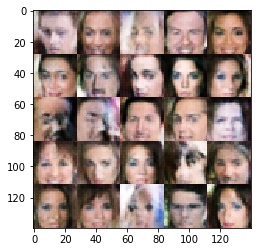

Epoch 1/1... Step 421/633.121875... Discriminator Loss: 1.4084... Generator Loss: 0.7290
Epoch 1/1... Step 422/633.121875... Discriminator Loss: 1.4287... Generator Loss: 0.7325
Epoch 1/1... Step 423/633.121875... Discriminator Loss: 1.4243... Generator Loss: 0.7215
Epoch 1/1... Step 424/633.121875... Discriminator Loss: 1.4110... Generator Loss: 0.7272
Epoch 1/1... Step 425/633.121875... Discriminator Loss: 1.4067... Generator Loss: 0.7255
Epoch 1/1... Step 426/633.121875... Discriminator Loss: 1.4040... Generator Loss: 0.7500
Epoch 1/1... Step 427/633.121875... Discriminator Loss: 1.4228... Generator Loss: 0.7327
Epoch 1/1... Step 428/633.121875... Discriminator Loss: 1.4016... Generator Loss: 0.7562
Epoch 1/1... Step 429/633.121875... Discriminator Loss: 1.4130... Generator Loss: 0.7410
Epoch 1/1... Step 430/633.121875... Discriminator Loss: 1.4155... Generator Loss: 0.7253


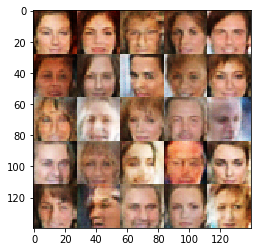

Epoch 1/1... Step 431/633.121875... Discriminator Loss: 1.4144... Generator Loss: 0.7363
Epoch 1/1... Step 432/633.121875... Discriminator Loss: 1.4331... Generator Loss: 0.7130
Epoch 1/1... Step 433/633.121875... Discriminator Loss: 1.3944... Generator Loss: 0.7323
Epoch 1/1... Step 434/633.121875... Discriminator Loss: 1.4164... Generator Loss: 0.7179
Epoch 1/1... Step 435/633.121875... Discriminator Loss: 1.4216... Generator Loss: 0.7367
Epoch 1/1... Step 436/633.121875... Discriminator Loss: 1.4323... Generator Loss: 0.7020
Epoch 1/1... Step 437/633.121875... Discriminator Loss: 1.4279... Generator Loss: 0.7279
Epoch 1/1... Step 438/633.121875... Discriminator Loss: 1.4129... Generator Loss: 0.7260
Epoch 1/1... Step 439/633.121875... Discriminator Loss: 1.4005... Generator Loss: 0.7627
Epoch 1/1... Step 440/633.121875... Discriminator Loss: 1.4527... Generator Loss: 0.6889


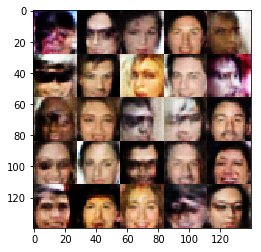

Epoch 1/1... Step 441/633.121875... Discriminator Loss: 1.4440... Generator Loss: 0.7086
Epoch 1/1... Step 442/633.121875... Discriminator Loss: 1.4290... Generator Loss: 0.7165
Epoch 1/1... Step 443/633.121875... Discriminator Loss: 1.4245... Generator Loss: 0.7285
Epoch 1/1... Step 444/633.121875... Discriminator Loss: 1.4089... Generator Loss: 0.7293
Epoch 1/1... Step 445/633.121875... Discriminator Loss: 1.4217... Generator Loss: 0.7206
Epoch 1/1... Step 446/633.121875... Discriminator Loss: 1.4136... Generator Loss: 0.7324
Epoch 1/1... Step 447/633.121875... Discriminator Loss: 1.4082... Generator Loss: 0.7237
Epoch 1/1... Step 448/633.121875... Discriminator Loss: 1.3984... Generator Loss: 0.7350
Epoch 1/1... Step 449/633.121875... Discriminator Loss: 1.4341... Generator Loss: 0.7192
Epoch 1/1... Step 450/633.121875... Discriminator Loss: 1.4712... Generator Loss: 0.6661


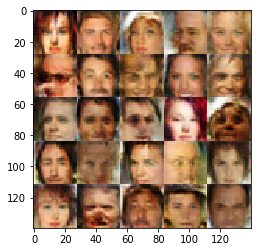

Epoch 1/1... Step 451/633.121875... Discriminator Loss: 1.4091... Generator Loss: 0.7399
Epoch 1/1... Step 452/633.121875... Discriminator Loss: 1.3966... Generator Loss: 0.7565
Epoch 1/1... Step 453/633.121875... Discriminator Loss: 1.4023... Generator Loss: 0.7353
Epoch 1/1... Step 454/633.121875... Discriminator Loss: 1.4332... Generator Loss: 0.7292
Epoch 1/1... Step 455/633.121875... Discriminator Loss: 1.4258... Generator Loss: 0.7120
Epoch 1/1... Step 456/633.121875... Discriminator Loss: 1.4650... Generator Loss: 0.6888
Epoch 1/1... Step 457/633.121875... Discriminator Loss: 1.3883... Generator Loss: 0.7533
Epoch 1/1... Step 458/633.121875... Discriminator Loss: 1.4074... Generator Loss: 0.7253
Epoch 1/1... Step 459/633.121875... Discriminator Loss: 1.4228... Generator Loss: 0.7388
Epoch 1/1... Step 460/633.121875... Discriminator Loss: 1.4007... Generator Loss: 0.7399


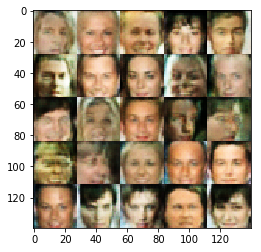

Epoch 1/1... Step 461/633.121875... Discriminator Loss: 1.4127... Generator Loss: 0.7404
Epoch 1/1... Step 462/633.121875... Discriminator Loss: 1.4445... Generator Loss: 0.7085
Epoch 1/1... Step 463/633.121875... Discriminator Loss: 1.4381... Generator Loss: 0.7104
Epoch 1/1... Step 464/633.121875... Discriminator Loss: 1.3992... Generator Loss: 0.7755
Epoch 1/1... Step 465/633.121875... Discriminator Loss: 1.4078... Generator Loss: 0.7575
Epoch 1/1... Step 466/633.121875... Discriminator Loss: 1.4152... Generator Loss: 0.7437
Epoch 1/1... Step 467/633.121875... Discriminator Loss: 1.4213... Generator Loss: 0.7168
Epoch 1/1... Step 468/633.121875... Discriminator Loss: 1.4247... Generator Loss: 0.7160
Epoch 1/1... Step 469/633.121875... Discriminator Loss: 1.4568... Generator Loss: 0.6894
Epoch 1/1... Step 470/633.121875... Discriminator Loss: 1.4015... Generator Loss: 0.7241


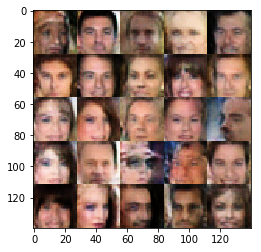

Epoch 1/1... Step 471/633.121875... Discriminator Loss: 1.4209... Generator Loss: 0.7328
Epoch 1/1... Step 472/633.121875... Discriminator Loss: 1.4357... Generator Loss: 0.7304
Epoch 1/1... Step 473/633.121875... Discriminator Loss: 1.3979... Generator Loss: 0.7747
Epoch 1/1... Step 474/633.121875... Discriminator Loss: 1.4209... Generator Loss: 0.7306
Epoch 1/1... Step 475/633.121875... Discriminator Loss: 1.4245... Generator Loss: 0.7310
Epoch 1/1... Step 476/633.121875... Discriminator Loss: 1.4080... Generator Loss: 0.7488
Epoch 1/1... Step 477/633.121875... Discriminator Loss: 1.3823... Generator Loss: 0.7771
Epoch 1/1... Step 478/633.121875... Discriminator Loss: 1.4862... Generator Loss: 0.6700
Epoch 1/1... Step 479/633.121875... Discriminator Loss: 1.3985... Generator Loss: 0.7345
Epoch 1/1... Step 480/633.121875... Discriminator Loss: 1.4203... Generator Loss: 0.7097


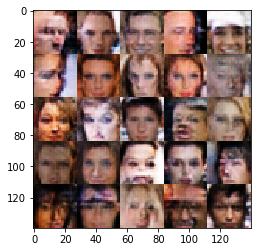

Epoch 1/1... Step 481/633.121875... Discriminator Loss: 1.3882... Generator Loss: 0.7469
Epoch 1/1... Step 482/633.121875... Discriminator Loss: 1.4361... Generator Loss: 0.7050
Epoch 1/1... Step 483/633.121875... Discriminator Loss: 1.4102... Generator Loss: 0.7581
Epoch 1/1... Step 484/633.121875... Discriminator Loss: 1.4170... Generator Loss: 0.7051
Epoch 1/1... Step 485/633.121875... Discriminator Loss: 1.4445... Generator Loss: 0.6953
Epoch 1/1... Step 486/633.121875... Discriminator Loss: 1.4206... Generator Loss: 0.7466
Epoch 1/1... Step 487/633.121875... Discriminator Loss: 1.4108... Generator Loss: 0.7558
Epoch 1/1... Step 488/633.121875... Discriminator Loss: 1.4307... Generator Loss: 0.7114
Epoch 1/1... Step 489/633.121875... Discriminator Loss: 1.4565... Generator Loss: 0.7205
Epoch 1/1... Step 490/633.121875... Discriminator Loss: 1.4312... Generator Loss: 0.7137


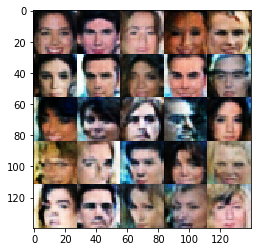

Epoch 1/1... Step 491/633.121875... Discriminator Loss: 1.3984... Generator Loss: 0.7445
Epoch 1/1... Step 492/633.121875... Discriminator Loss: 1.4229... Generator Loss: 0.7454
Epoch 1/1... Step 493/633.121875... Discriminator Loss: 1.4555... Generator Loss: 0.6908
Epoch 1/1... Step 494/633.121875... Discriminator Loss: 1.3967... Generator Loss: 0.7573
Epoch 1/1... Step 495/633.121875... Discriminator Loss: 1.3990... Generator Loss: 0.7393
Epoch 1/1... Step 496/633.121875... Discriminator Loss: 1.4133... Generator Loss: 0.7456
Epoch 1/1... Step 497/633.121875... Discriminator Loss: 1.4009... Generator Loss: 0.7310
Epoch 1/1... Step 498/633.121875... Discriminator Loss: 1.4387... Generator Loss: 0.7153
Epoch 1/1... Step 499/633.121875... Discriminator Loss: 1.4024... Generator Loss: 0.7677
Epoch 1/1... Step 500/633.121875... Discriminator Loss: 1.4541... Generator Loss: 0.7043


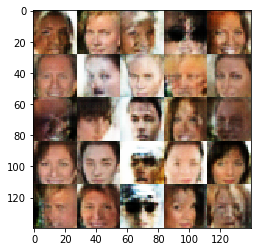

Epoch 1/1... Step 501/633.121875... Discriminator Loss: 1.3969... Generator Loss: 0.7317
Epoch 1/1... Step 502/633.121875... Discriminator Loss: 1.4411... Generator Loss: 0.6931
Epoch 1/1... Step 503/633.121875... Discriminator Loss: 1.4282... Generator Loss: 0.7014
Epoch 1/1... Step 504/633.121875... Discriminator Loss: 1.3950... Generator Loss: 0.7744
Epoch 1/1... Step 505/633.121875... Discriminator Loss: 1.4291... Generator Loss: 0.7160
Epoch 1/1... Step 506/633.121875... Discriminator Loss: 1.3994... Generator Loss: 0.7519
Epoch 1/1... Step 507/633.121875... Discriminator Loss: 1.4325... Generator Loss: 0.7320
Epoch 1/1... Step 508/633.121875... Discriminator Loss: 1.4050... Generator Loss: 0.7319
Epoch 1/1... Step 509/633.121875... Discriminator Loss: 1.4263... Generator Loss: 0.7257
Epoch 1/1... Step 510/633.121875... Discriminator Loss: 1.4339... Generator Loss: 0.7339


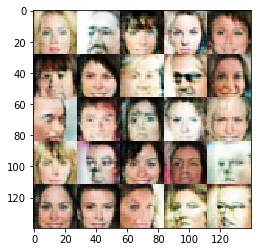

Epoch 1/1... Step 511/633.121875... Discriminator Loss: 1.4234... Generator Loss: 0.7218
Epoch 1/1... Step 512/633.121875... Discriminator Loss: 1.4201... Generator Loss: 0.7190
Epoch 1/1... Step 513/633.121875... Discriminator Loss: 1.4087... Generator Loss: 0.7364
Epoch 1/1... Step 514/633.121875... Discriminator Loss: 1.4444... Generator Loss: 0.6955
Epoch 1/1... Step 515/633.121875... Discriminator Loss: 1.4282... Generator Loss: 0.7194
Epoch 1/1... Step 516/633.121875... Discriminator Loss: 1.3864... Generator Loss: 0.7681
Epoch 1/1... Step 517/633.121875... Discriminator Loss: 1.4093... Generator Loss: 0.7455
Epoch 1/1... Step 518/633.121875... Discriminator Loss: 1.4074... Generator Loss: 0.7533
Epoch 1/1... Step 519/633.121875... Discriminator Loss: 1.4010... Generator Loss: 0.7539
Epoch 1/1... Step 520/633.121875... Discriminator Loss: 1.3864... Generator Loss: 0.7523


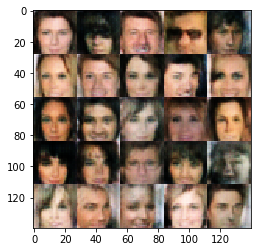

Epoch 1/1... Step 521/633.121875... Discriminator Loss: 1.4372... Generator Loss: 0.7199
Epoch 1/1... Step 522/633.121875... Discriminator Loss: 1.4106... Generator Loss: 0.7355
Epoch 1/1... Step 523/633.121875... Discriminator Loss: 1.4814... Generator Loss: 0.6549
Epoch 1/1... Step 524/633.121875... Discriminator Loss: 1.3771... Generator Loss: 0.7839
Epoch 1/1... Step 525/633.121875... Discriminator Loss: 1.4085... Generator Loss: 0.7371
Epoch 1/1... Step 526/633.121875... Discriminator Loss: 1.4297... Generator Loss: 0.7160
Epoch 1/1... Step 527/633.121875... Discriminator Loss: 1.4502... Generator Loss: 0.7185
Epoch 1/1... Step 528/633.121875... Discriminator Loss: 1.3971... Generator Loss: 0.7726
Epoch 1/1... Step 529/633.121875... Discriminator Loss: 1.4032... Generator Loss: 0.7557
Epoch 1/1... Step 530/633.121875... Discriminator Loss: 1.4036... Generator Loss: 0.7500


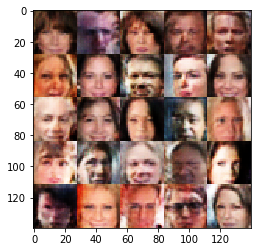

Epoch 1/1... Step 531/633.121875... Discriminator Loss: 1.4053... Generator Loss: 0.7509
Epoch 1/1... Step 532/633.121875... Discriminator Loss: 1.3948... Generator Loss: 0.7587
Epoch 1/1... Step 533/633.121875... Discriminator Loss: 1.4152... Generator Loss: 0.7383
Epoch 1/1... Step 534/633.121875... Discriminator Loss: 1.4081... Generator Loss: 0.7265
Epoch 1/1... Step 535/633.121875... Discriminator Loss: 1.4037... Generator Loss: 0.7223
Epoch 1/1... Step 536/633.121875... Discriminator Loss: 1.4184... Generator Loss: 0.7377
Epoch 1/1... Step 537/633.121875... Discriminator Loss: 1.3876... Generator Loss: 0.7756
Epoch 1/1... Step 538/633.121875... Discriminator Loss: 1.3756... Generator Loss: 0.7721
Epoch 1/1... Step 539/633.121875... Discriminator Loss: 1.3932... Generator Loss: 0.7607
Epoch 1/1... Step 540/633.121875... Discriminator Loss: 1.4063... Generator Loss: 0.7675


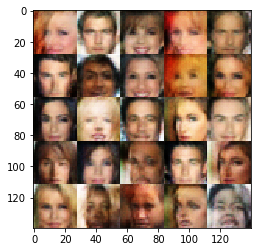

Epoch 1/1... Step 541/633.121875... Discriminator Loss: 1.4015... Generator Loss: 0.7293
Epoch 1/1... Step 542/633.121875... Discriminator Loss: 1.4462... Generator Loss: 0.7216
Epoch 1/1... Step 543/633.121875... Discriminator Loss: 1.4258... Generator Loss: 0.7362
Epoch 1/1... Step 544/633.121875... Discriminator Loss: 1.4069... Generator Loss: 0.7677
Epoch 1/1... Step 545/633.121875... Discriminator Loss: 1.4163... Generator Loss: 0.7235
Epoch 1/1... Step 546/633.121875... Discriminator Loss: 1.4084... Generator Loss: 0.7459
Epoch 1/1... Step 547/633.121875... Discriminator Loss: 1.4125... Generator Loss: 0.7263
Epoch 1/1... Step 548/633.121875... Discriminator Loss: 1.4258... Generator Loss: 0.7166
Epoch 1/1... Step 549/633.121875... Discriminator Loss: 1.3976... Generator Loss: 0.7539
Epoch 1/1... Step 550/633.121875... Discriminator Loss: 1.4099... Generator Loss: 0.7344


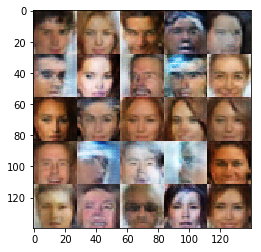

Epoch 1/1... Step 551/633.121875... Discriminator Loss: 1.4107... Generator Loss: 0.7526
Epoch 1/1... Step 552/633.121875... Discriminator Loss: 1.4223... Generator Loss: 0.7339
Epoch 1/1... Step 553/633.121875... Discriminator Loss: 1.4193... Generator Loss: 0.7096
Epoch 1/1... Step 554/633.121875... Discriminator Loss: 1.4289... Generator Loss: 0.7257
Epoch 1/1... Step 555/633.121875... Discriminator Loss: 1.4302... Generator Loss: 0.7369
Epoch 1/1... Step 556/633.121875... Discriminator Loss: 1.4060... Generator Loss: 0.7424
Epoch 1/1... Step 557/633.121875... Discriminator Loss: 1.3966... Generator Loss: 0.7373
Epoch 1/1... Step 558/633.121875... Discriminator Loss: 1.4121... Generator Loss: 0.7106
Epoch 1/1... Step 559/633.121875... Discriminator Loss: 1.4821... Generator Loss: 0.6680
Epoch 1/1... Step 560/633.121875... Discriminator Loss: 1.4097... Generator Loss: 0.7452


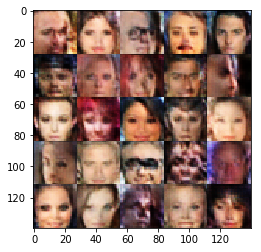

Epoch 1/1... Step 561/633.121875... Discriminator Loss: 1.4220... Generator Loss: 0.7245
Epoch 1/1... Step 562/633.121875... Discriminator Loss: 1.4295... Generator Loss: 0.7034
Epoch 1/1... Step 563/633.121875... Discriminator Loss: 1.4082... Generator Loss: 0.7387
Epoch 1/1... Step 564/633.121875... Discriminator Loss: 1.4043... Generator Loss: 0.7509
Epoch 1/1... Step 565/633.121875... Discriminator Loss: 1.3905... Generator Loss: 0.7716
Epoch 1/1... Step 566/633.121875... Discriminator Loss: 1.4010... Generator Loss: 0.7553
Epoch 1/1... Step 567/633.121875... Discriminator Loss: 1.4102... Generator Loss: 0.7539
Epoch 1/1... Step 568/633.121875... Discriminator Loss: 1.4257... Generator Loss: 0.7217
Epoch 1/1... Step 569/633.121875... Discriminator Loss: 1.4268... Generator Loss: 0.7194
Epoch 1/1... Step 570/633.121875... Discriminator Loss: 1.4076... Generator Loss: 0.7318


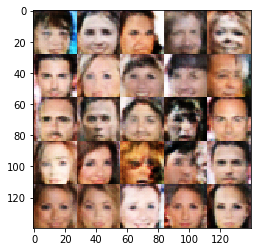

Epoch 1/1... Step 571/633.121875... Discriminator Loss: 1.3886... Generator Loss: 0.7396
Epoch 1/1... Step 572/633.121875... Discriminator Loss: 1.3862... Generator Loss: 0.7533
Epoch 1/1... Step 573/633.121875... Discriminator Loss: 1.4320... Generator Loss: 0.7285
Epoch 1/1... Step 574/633.121875... Discriminator Loss: 1.3931... Generator Loss: 0.7363
Epoch 1/1... Step 575/633.121875... Discriminator Loss: 1.4255... Generator Loss: 0.7058
Epoch 1/1... Step 576/633.121875... Discriminator Loss: 1.4235... Generator Loss: 0.7232
Epoch 1/1... Step 577/633.121875... Discriminator Loss: 1.4250... Generator Loss: 0.6870
Epoch 1/1... Step 578/633.121875... Discriminator Loss: 1.4164... Generator Loss: 0.7673
Epoch 1/1... Step 579/633.121875... Discriminator Loss: 1.4008... Generator Loss: 0.7224
Epoch 1/1... Step 580/633.121875... Discriminator Loss: 1.4296... Generator Loss: 0.7332


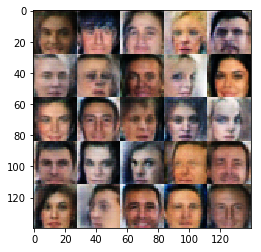

Epoch 1/1... Step 581/633.121875... Discriminator Loss: 1.4131... Generator Loss: 0.7162
Epoch 1/1... Step 582/633.121875... Discriminator Loss: 1.4206... Generator Loss: 0.7312
Epoch 1/1... Step 583/633.121875... Discriminator Loss: 1.4236... Generator Loss: 0.7236
Epoch 1/1... Step 584/633.121875... Discriminator Loss: 1.4171... Generator Loss: 0.7585
Epoch 1/1... Step 585/633.121875... Discriminator Loss: 1.3984... Generator Loss: 0.7561
Epoch 1/1... Step 586/633.121875... Discriminator Loss: 1.3986... Generator Loss: 0.7618
Epoch 1/1... Step 587/633.121875... Discriminator Loss: 1.4010... Generator Loss: 0.7573
Epoch 1/1... Step 588/633.121875... Discriminator Loss: 1.4124... Generator Loss: 0.7194
Epoch 1/1... Step 589/633.121875... Discriminator Loss: 1.4196... Generator Loss: 0.7501
Epoch 1/1... Step 590/633.121875... Discriminator Loss: 1.3827... Generator Loss: 0.7663


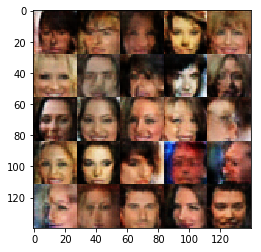

Epoch 1/1... Step 591/633.121875... Discriminator Loss: 1.4229... Generator Loss: 0.7181
Epoch 1/1... Step 592/633.121875... Discriminator Loss: 1.4028... Generator Loss: 0.7689
Epoch 1/1... Step 593/633.121875... Discriminator Loss: 1.4029... Generator Loss: 0.7316
Epoch 1/1... Step 594/633.121875... Discriminator Loss: 1.3895... Generator Loss: 0.7666
Epoch 1/1... Step 595/633.121875... Discriminator Loss: 1.4040... Generator Loss: 0.7413
Epoch 1/1... Step 596/633.121875... Discriminator Loss: 1.4024... Generator Loss: 0.7398
Epoch 1/1... Step 597/633.121875... Discriminator Loss: 1.4190... Generator Loss: 0.7695
Epoch 1/1... Step 598/633.121875... Discriminator Loss: 1.4080... Generator Loss: 0.7321
Epoch 1/1... Step 599/633.121875... Discriminator Loss: 1.4182... Generator Loss: 0.7253
Epoch 1/1... Step 600/633.121875... Discriminator Loss: 1.4153... Generator Loss: 0.7339


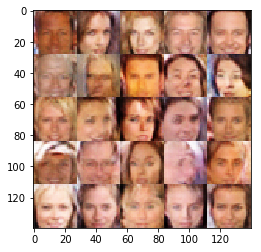

Epoch 1/1... Step 601/633.121875... Discriminator Loss: 1.4177... Generator Loss: 0.7175
Epoch 1/1... Step 602/633.121875... Discriminator Loss: 1.3784... Generator Loss: 0.7596
Epoch 1/1... Step 603/633.121875... Discriminator Loss: 1.4383... Generator Loss: 0.7026
Epoch 1/1... Step 604/633.121875... Discriminator Loss: 1.4205... Generator Loss: 0.7423
Epoch 1/1... Step 605/633.121875... Discriminator Loss: 1.3996... Generator Loss: 0.7487
Epoch 1/1... Step 606/633.121875... Discriminator Loss: 1.4079... Generator Loss: 0.7120
Epoch 1/1... Step 607/633.121875... Discriminator Loss: 1.4312... Generator Loss: 0.6920
Epoch 1/1... Step 608/633.121875... Discriminator Loss: 1.3931... Generator Loss: 0.7274
Epoch 1/1... Step 609/633.121875... Discriminator Loss: 1.4310... Generator Loss: 0.7175
Epoch 1/1... Step 610/633.121875... Discriminator Loss: 1.4195... Generator Loss: 0.7473


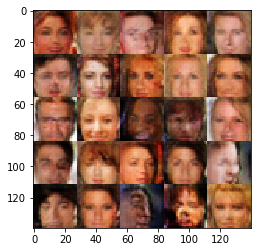

Epoch 1/1... Step 611/633.121875... Discriminator Loss: 1.4214... Generator Loss: 0.7407
Epoch 1/1... Step 612/633.121875... Discriminator Loss: 1.4239... Generator Loss: 0.7243
Epoch 1/1... Step 613/633.121875... Discriminator Loss: 1.4074... Generator Loss: 0.7478
Epoch 1/1... Step 614/633.121875... Discriminator Loss: 1.3892... Generator Loss: 0.7449
Epoch 1/1... Step 615/633.121875... Discriminator Loss: 1.3938... Generator Loss: 0.7395
Epoch 1/1... Step 616/633.121875... Discriminator Loss: 1.4073... Generator Loss: 0.7511
Epoch 1/1... Step 617/633.121875... Discriminator Loss: 1.4115... Generator Loss: 0.7315
Epoch 1/1... Step 618/633.121875... Discriminator Loss: 1.3951... Generator Loss: 0.7497
Epoch 1/1... Step 619/633.121875... Discriminator Loss: 1.3709... Generator Loss: 0.7549
Epoch 1/1... Step 620/633.121875... Discriminator Loss: 1.4242... Generator Loss: 0.7433


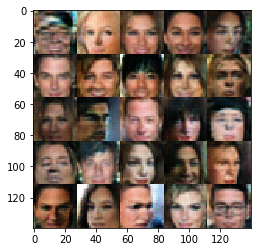

Epoch 1/1... Step 621/633.121875... Discriminator Loss: 1.4043... Generator Loss: 0.7125
Epoch 1/1... Step 622/633.121875... Discriminator Loss: 1.4517... Generator Loss: 0.6762
Epoch 1/1... Step 623/633.121875... Discriminator Loss: 1.4023... Generator Loss: 0.7354
Epoch 1/1... Step 624/633.121875... Discriminator Loss: 1.4018... Generator Loss: 0.7414
Epoch 1/1... Step 625/633.121875... Discriminator Loss: 1.3885... Generator Loss: 0.7570
Epoch 1/1... Step 626/633.121875... Discriminator Loss: 1.4079... Generator Loss: 0.7021
Epoch 1/1... Step 627/633.121875... Discriminator Loss: 1.4066... Generator Loss: 0.7511
Epoch 1/1... Step 628/633.121875... Discriminator Loss: 1.4123... Generator Loss: 0.7394
Epoch 1/1... Step 629/633.121875... Discriminator Loss: 1.3895... Generator Loss: 0.7551
Epoch 1/1... Step 630/633.121875... Discriminator Loss: 1.4166... Generator Loss: 0.7216


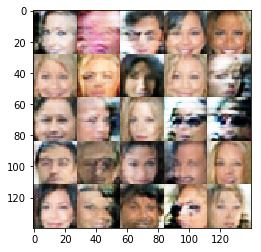

Epoch 1/1... Step 631/633.121875... Discriminator Loss: 1.4020... Generator Loss: 0.7477
Epoch 1/1... Step 632/633.121875... Discriminator Loss: 1.4138... Generator Loss: 0.7209
Epoch 1/1... Step 633/633.121875... Discriminator Loss: 1.4137... Generator Loss: 0.7369


In [49]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = .5
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.